In [24]:
import pandas as pd
import geopandas as gpd
import geodatasets
import folium
from folium.plugins import MarkerCluster
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
from scipy import stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from scipy.stats import pearsonr
from shapely.geometry import Point
import seaborn as sns
import xarray as xr
import netCDF4 as nc
import requests
import pymannkendall as mk
from tqdm import tqdm
import warnings

#### Load data and render map showing location of RLS monitoring sites

In [2]:
# 1. Load station metadata
df_stations = pd.read_csv(os.path.join("~/multitressor/", "survey_latlon_date.csv"))

# 2. Initialize the map with Satellite Imagery
# We use Esri.WorldImagery for the satellite background
m = folium.Map(
    location=[24.8, -80.8], 
    zoom_start=8, 
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Esri Satellite'
)

# 3. Add stations to the map
marker_cluster = MarkerCluster().add_to(m)

for idx, row in df_stations.iterrows():
    if pd.notnull(row['latitude']) and pd.notnull(row['longitude']):
        # Popup string formatted as a list-style block
        popup_text = f"""
        Station: {row.get('site_name', 'N/A')}
        <br>ID: {row.get('site_code', 'N/A')}
        <br>Habitat: {row.get('habitat', 'N/A')}
        <br>Date Surveyed: {row.get('survey_date', 'N/A')} ft
        """
        
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=folium.Popup(popup_text, max_width=300),
            tooltip=row.get('site_name', 'Click for info')
        ).add_to(marker_cluster)

# Display the map
m

#### Load daily and monthly SST

In [3]:
#Define paths to your merged datasets
path_daily = "/home/enrique.montes@CNS.local/multitressor/SST_Daily_Merged_2002_2025.nc"
path_monthly = "/home/enrique.montes@CNS.local/multitressor/SST_Monthly_Data_Subset.nc"

print("Checking for files...")
for p in [path_daily, path_monthly]:
    if os.path.exists(p):
        print(f"  [OK] Found: {os.path.basename(p)}")
    else:
        print(f"  [MISSING] Could not find: {p}")

# Load the datasets
try:
    # We use chunks={} to enable dask-backed lazy loading for the large daily file
    ds_sst_daily = xr.open_dataset(path_daily, chunks={'time': 500})
    print("\nDaily Merged SST loaded successfully.")
    
    ds_sst_monthly = xr.open_dataset(path_monthly)
    print("Monthly SST Subset loaded successfully.")
    
    # Display the daily dataset to check time range and variables
    display(ds_sst_daily)

except Exception as e:
    print(f"\nError loading datasets: {e}")

Checking for files...
  [OK] Found: SST_Daily_Merged_2002_2025.nc
  [OK] Found: SST_Monthly_Data_Subset.nc

Daily Merged SST loaded successfully.
Monthly SST Subset loaded successfully.


<xarray.Dataset> Size: 4GB
Dimensions:    (time: 8598, latitude: 101, longitude: 351)
Coordinates:
  * time       (time) datetime64[ns] 69kB 2002-06-16T09:00:00 ... 2025-12-31T...
  * latitude   (latitude) float32 404B 24.4 24.41 24.42 ... 25.38 25.39 25.4
  * longitude  (longitude) float32 1kB -83.0 -82.99 -82.98 ... -79.51 -79.5
Data variables:
    sst        (time, latitude, longitude) float64 2GB dask.array<chunksize=(500, 101, 351), meta=np.ndarray>
    mask       (time, latitude, longitude) float32 1GB dask.array<chunksize=(500, 101, 351), meta=np.ndarray>
Attributes: (12/50)
    acknowledgement:            Please acknowledge the use of these data with...
    cdm_data_type:              Grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    Conventions:                CF-1.6, COARDS, ACDD-1.3
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    creator_name:               JPL MUR SST project
    ...                         ...
    summary:                    This is a merged, multi-sensor L4 Foundation ...
    testOutOfDate:              now-3days
    time_coverage_end:          2002-12-31T09:00:00Z
    time_coverage_start:        2002-06-16T09:00:00Z
    title:                      Multi-scale Ultra-high Resolution (MUR) SST A...
    Westernmost_Easting:        -83.0

#### Extract SST for RLS Stations

Extracting 3x3 pixel data. Mode: Monthly


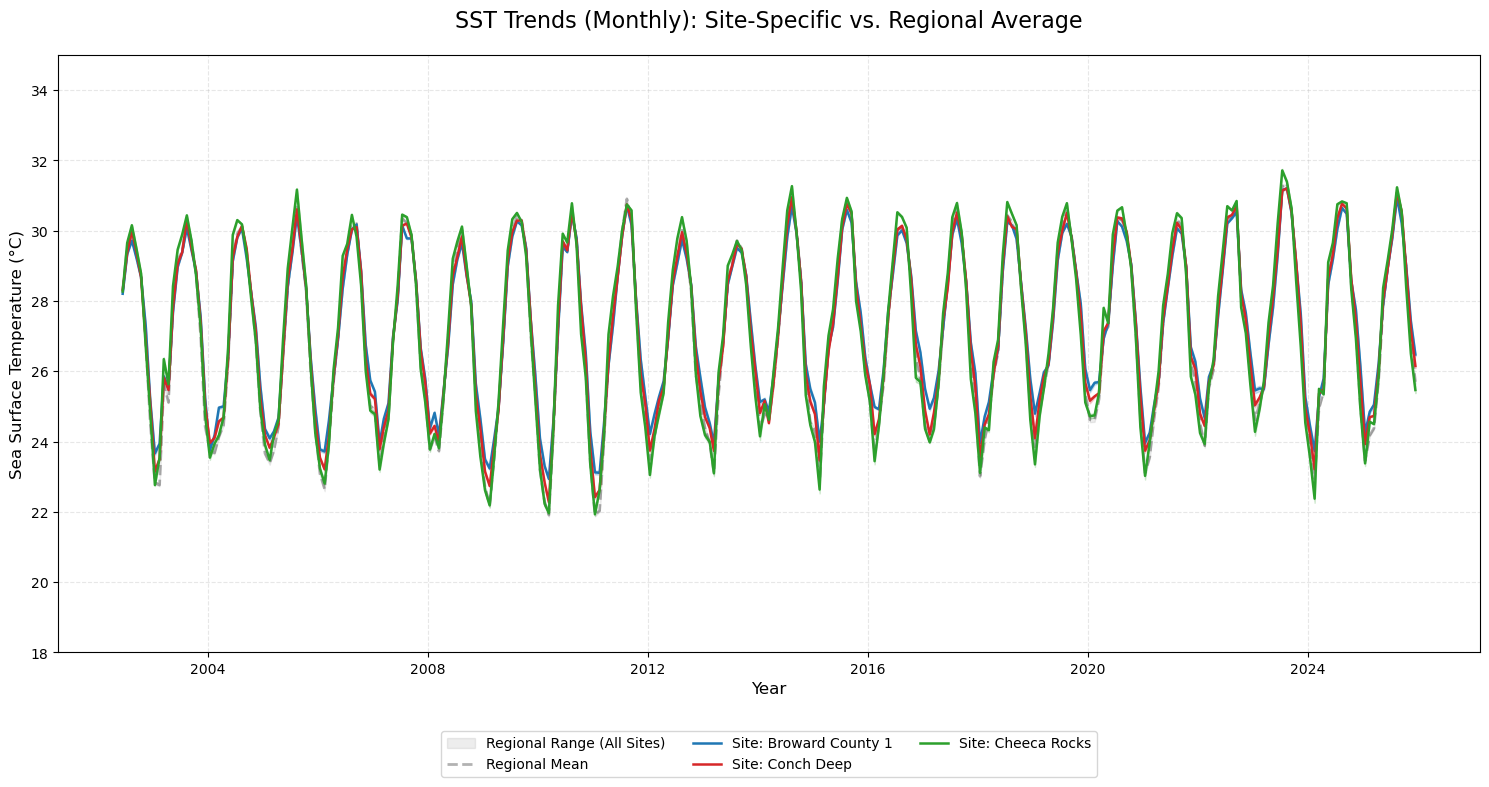

In [20]:
# Select either ds_sst_daily or ds_sst_monthly as needed
ds_input = ds_sst_monthly 

# 1. Prepare unique site list
df_unique_sites = df_stations[['site_name', 'latitude', 'longitude']].drop_duplicates(subset='site_name')

# 2. Iteratively extract 3x3 pixel box for each site
site_sst_results = {}

# Detect if the dataset is daily or monthly based on the time delta
time_diff = ds_input.time.diff('time').median().values / np.timedelta64(1, 'D')
is_daily = time_diff < 5  # True if data is daily (~1 day), False if monthly (~30 days)

print(f"Extracting 3x3 pixel data. Mode: {'Daily -> Resampled Monthly' if is_daily else 'Monthly'}")

for idx, row in df_unique_sites.iterrows():
    site = row['site_name']
    lat, lon = row['latitude'], row['longitude']
    
    # Find center indices
    center_ds = ds_input.sel(latitude=lat, longitude=lon, method='nearest')
    lat_idx = np.abs(ds_input.latitude - center_ds.latitude).argmin().item()
    lon_idx = np.abs(ds_input.longitude - center_ds.longitude).argmin().item()
    
    # Extract 3x3 grid
    subset = ds_input.sst.isel(
        latitude=slice(lat_idx - 1, lat_idx + 2),
        longitude=slice(lon_idx - 1, lon_idx + 2)
    )
    
    # Calculate spatial mean for the 3x3 box
    spatial_mean = subset.mean(dim=['latitude', 'longitude'])
    
    if is_daily:
        # AGGREGATION: Resample daily spatial means to monthly mean and SD
        # 'MS' = Month Start frequency
        site_mean = spatial_mean.resample(time='MS').mean()
        site_std = spatial_mean.resample(time='MS').std()
    else:
        # Standard spatial SD for monthly data
        site_mean = spatial_mean
        site_std = subset.std(dim=['latitude', 'longitude'])
    
    # Convert to dataframe
    df_site = pd.DataFrame({
        'Date': site_mean.time.values,
        'SST_Mean': site_mean.values,
        'SST_SD': site_std.values
    }).dropna() # Drop any months with missing data
    
    df_site['site_name'] = site
    site_sst_results[site] = df_site

# Combine all sites
df_sst_master = pd.concat(site_sst_results.values(), ignore_index=True)

# 3. Plotting with Regional Reference
selected_sites = ['Broward County 1', 'Conch Deep', 'Cheeca Rocks']
colors = {'Broward County 1': '#1f77b4', 'Conch Deep': '#d62728', 'Cheeca Rocks': '#2ca02c'}

# Group by Date to get the regional average
regional_ref = df_sst_master.groupby('Date').agg({
    'SST_Mean': 'mean',
    'SST_SD': 'mean'
}).reset_index()

plt.figure(figsize=(15, 8))

# Background Regional Reference
plt.fill_between(regional_ref['Date'], 
                 regional_ref['SST_Mean'] - regional_ref['SST_SD'], 
                 regional_ref['SST_Mean'] + regional_ref['SST_SD'], 
                 color='black', alpha=0.07, label='Regional Range (All Sites)')
plt.plot(regional_ref['Date'], regional_ref['SST_Mean'], 
         color='black', linestyle='--', linewidth=2, alpha=0.3, label='Regional Mean')

# Plot Selected Sites
for site in selected_sites:
    plot_data = site_sst_results.get(site)
    if plot_data is not None:
        plt.fill_between(plot_data['Date'], 
                         plot_data['SST_Mean'] - plot_data['SST_SD'], 
                         plot_data['SST_Mean'] + plot_data['SST_SD'], 
                         color=colors[site], alpha=0.2)
        plt.plot(plot_data['Date'], plot_data['SST_Mean'], 
                 color=colors[site], linewidth=1.8, label=f'Site: {site}')

# Formatting and Titles
data_mode = "Daily Aggregated" if is_daily else "Monthly"
plt.title(f'SST Trends ({data_mode}): Site-Specific vs. Regional Average', fontsize=16, pad=20)
plt.ylabel('Sea Surface Temperature (°C)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.ylim(18, 35) 
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3, frameon=True)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

#### SST distribution by site (ordered by median)

In [ ]:
# 1. Prepare Data and Color Mapping
# Calculate the median SST and sort for the color mapping
site_medians = df_sst_master.groupby('site_name')['SST_Mean'].median().sort_values()
site_order = site_medians.index
df_coords = df_stations[['site_name', 'latitude', 'longitude', 'region']].drop_duplicates(subset='site_name')

# Identify Highest and Lowest sites
lowest_site_name = site_order[0]
highest_site_name = site_order[-1]

# Generate the Color Map (matching 'magma')
norm = mcolors.Normalize(vmin=0, vmax=len(site_order)-1)
cmap = plt.get_cmap('magma')
site_colors = {site: cmap(norm(i)) for i, site in enumerate(site_order)}

# Symbol Logic Mapping
marker_map = {'BC': 's', 'LK': '^', 'DT': 'v', 'DC': '*', 'MQ': 'D', 'MC': '<', 'PB': '>', 'MK': '+', 'UK': 'o'}

# --- FIGURE SETUP ---
fig = plt.figure(figsize=(16, 22))

# --- TOP: THE BOX PLOT ---
ax1 = fig.add_subplot(2, 1, 1)
sns.boxplot(
    data=df_sst_master, 
    x='site_name', 
    y='SST_Mean', 
    order=site_order, 
    palette='magma',
    ax=ax1,
    fliersize=1,
    linewidth=1.2,
    medianprops={'color': 'lightgrey', 'linewidth': 2}
)

ax1.axhline(27, color='red', linestyle='--', linewidth=2, label='Threshold: 27°C')
ax1.text(-0.5, 27.2, '27°C', color='red', fontweight='bold', fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize=10)
ax1.set_title('Thermal Signatures: SST Distribution Ordered by Median', fontsize=16, pad=15)
ax1.set_ylabel('Sea Surface Temperature (°C)', fontsize=12)

# --- BOTTOM: THE MAP ---
ax2 = fig.add_subplot(2, 1, 2, projection=ccrs.PlateCarree())
ax2.set_extent([df_coords['longitude'].min()-0.2, df_coords['longitude'].max()+0.2, 
                df_coords['latitude'].min()-0.2, df_coords['latitude'].max()+0.2])

ax2.add_feature(cfeature.LAND.with_scale('10m'), facecolor='#d9d9d9')
ax2.add_feature(cfeature.OCEAN.with_scale('10m'), facecolor='#eef7ff')
ax2.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8)

# Plot sites using both Color (Temperature) and Shape (Subregion)
for site in site_order:
    coords = df_coords[df_coords['site_name'] == site]
    if not coords.empty:
        lon, lat = coords['longitude'].iloc[0], coords['latitude'].iloc[0]
        subregion = coords['region'].iloc[0]
        
        # Determine dot color and marker shape
        current_color = site_colors[site]
        current_marker = marker_map.get(subregion, 'o') # Default to circle if not found
        
        ax2.scatter(lon, lat, color=current_color, marker=current_marker,
                    s=160, edgecolor='black', zorder=3, transform=ccrs.PlateCarree())
        
        # Annotate MIN/MAX sites
        if site == lowest_site_name or site == highest_site_name:
            prefix = "MIN" if site == lowest_site_name else "MAX"
            label_text = f"{prefix}: {site}\n({site_medians[site]:.2f}°C)"
            ax2.text(lon + 0.03, lat + 0.03, label_text,
                     transform=ccrs.PlateCarree(), fontsize=11, fontweight='bold',
                     bbox=dict(facecolor='white', alpha=0.9, edgecolor=current_color, boxstyle='round,pad=0.4'),
                     zorder=5)

# --- ADD LEGENDS ---
# 1. Temperature Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=site_medians.min(), vmax=site_medians.max()))
cbar = plt.colorbar(sm, ax=ax2, orientation='horizontal', shrink=0.5, pad=0.08)
cbar.set_label('Median SST (°C)', fontsize=12)

# 2. Subregion Symbol Legend
symbol_legend = [Line2D([0], [0], marker=m, color='w', label=k,
                        markerfacecolor='gray', markersize=10, markeredgecolor='k') 
                 for k, m in marker_map.items()]
ax2.legend(handles=symbol_legend, loc='lower left', title="Subregions", frameon=True, fontsize=10)

ax2.set_title('Spatial Distribution of Thermal Medians\n(Shape = Subregion, Color = Temperature)', fontsize=16, pad=15)

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.show()

# --- SUBREGION THERMAL DISTRIBUTION ---

# 1. Prepare a dataframe of site medians with their subregions
df_site_medians = site_medians.reset_index()
df_site_medians.columns = ['site_name', 'Median_SST']

# Merge with coordinates to get the Subregion column
df_subregion_medians = pd.merge(df_site_medians, df_coords[['site_name', 'region']], left_on='site_name', right_on='site_name')

# 2. Render the Box Plot
plt.figure(figsize=(10, 7))
sns.set_theme(style="whitegrid")

# Create the boxplot
ax_sub = sns.boxplot(
    data=df_subregion_medians, 
    x='region', 
    y='Median_SST', 
    palette='Set2', 
    showfliers=False,
    width=0.6
)

# Overlay individual site medians as points to show distribution density
sns.stripplot(
    data=df_subregion_medians, 
    x='region', 
    y='Median_SST', 
    color='black', 
    alpha=0.4, 
    jitter=True,
    size=7
)

# 3. Formatting
plt.title('Distribution of Thermal Medians by Subregion', fontsize=16, fontweight='bold', pad=15)
plt.ylabel('Median SST (°C)', fontsize=13)
plt.xlabel('Subregion', fontsize=13)

# Add a reference line for the overall network median
network_median = df_subregion_medians['Median_SST'].median()
plt.axhline(network_median, color='red', linestyle='--', linewidth=1.5, label=f'Network Median: {network_median:.2f}°C')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Print Descriptive Statistics
print("\nDescriptive Statistics for Thermal Medians per Subregion:")
display(df_subregion_medians.groupby('region')['Median_SST'].describe().round(3))

#### Mann-Kendall on deseasonalized monthly anomalies

In [ ]:
# 1. Initialize list to store results
mk_anomaly_results = []

print("Calculating Deseasonalized Monthly Anomalies and MK Trends...")

# 2. Iterate through each site
for site_name, df_site in tqdm(site_sst_results.items()):
    
    # Create a copy and ensure Date is datetime
    df = df_site.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    
    # A. Resample to Monthly Mean
    # Ensure we produce a Series for the mapping to work smoothly
    df_monthly = df['SST_Mean'].resample('MS').mean().to_frame()
    
    # B. Calculate Climatology (Average for each month 1-12)
    df_monthly['Month'] = df_monthly.index.month
    climatology = df_monthly.groupby('Month')['SST_Mean'].mean()
    
    # C. Subtract Climatology to get Anomaly (Vectorized Fix)
    # .map() is faster and avoids the ValueError from .apply()
    df_monthly['Anomaly'] = df_monthly['SST_Mean'] - df_monthly['Month'].map(climatology)
    
    # D. Perform Mann-Kendall on the Anomaly
    data = df_monthly['Anomaly'].dropna().values
    
    if len(data) > 24: # Require at least 2 years of data
        res = mk.original_test(data)
        
        # E. Convert Slope to Decadal
        # Slope is °C/month -> *12 (Annual) *10 (Decadal)
        slope_per_decade = res.slope * 12 * 10
        
        mk_anomaly_results.append({
            'SiteName': site_name,
            'Trend': res.trend,
            'P_Value': res.p,
            'Z_Value': res.z,
            'Slope_Decade': slope_per_decade,
            'Significant': 'Significant' if res.p <= 0.05 else 'Not Significant'
        })

# 3. Create Summary DataFrame
df_mk_trends = pd.DataFrame(mk_anomaly_results)

print("\nAnomalous Trend Summary (Decadal):")
display(df_mk_trends.sort_values('Slope_Decade', ascending=False).head(10))

sig_sites = df_mk_trends[df_mk_trends['Significant'] == 'Significant']
print(f"Found {len(sig_sites)} sites with significant warming trends.")

#### SST trend distribution and spatial hotspots

In [ ]:
# --- 1. DATA PREPARATION ---
# Filter for significant trends and merge with coordinates
df_sig_trends = df_mk_trends[df_mk_trends['Significant'] == 'Significant'].copy()

# Ensure df_coords has 'Subregion' before merging
df_sig_coords = pd.merge(df_sig_trends, df_coords, left_on='SiteName', right_on='site_name')

# Identify the 80th percentile threshold for the "Top Warming" sites
slope_threshold = df_sig_trends['Slope_Decade'].quantile(0.8)
df_high_warming = df_sig_coords[df_sig_coords['Slope_Decade'] >= slope_threshold]

# Symbol Logic Mapping
marker_map = {'BC': 's', 'LK': '^', 'DT': 'v', 'DC': '*', 'MQ': 'D', 'MC': '<', 'PB': '>', 'MK': '+', 'UK': 'o'}

# --- 2. PLOTTING ---
fig = plt.figure(figsize=(16, 12)) 

ax2 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax2.set_extent([df_coords['longitude'].min()-0.2, df_coords['longitude'].max()+0.2, 
                df_coords['latitude'].min()-0.2, df_coords['latitude'].max()+0.2])

ax2.add_feature(cfeature.LAND.with_scale('10m'), facecolor='#d9d9d9')
ax2.add_feature(cfeature.OCEAN.with_scale('10m'), facecolor='#eef7ff')
ax2.add_feature(cfeature.COASTLINE.with_scale('10m'))

# Define normalization for consistent color mapping across markers
vmin = df_sig_coords['Slope_Decade'].min()
vmax = df_sig_coords['Slope_Decade'].max()
norm_slope = mcolors.Normalize(vmin=vmin, vmax=vmax)

# --- ITERATIVE PLOTTING BY SUBREGION ---
sc = None
for sub, mkr in marker_map.items():
    sub_data = df_sig_coords[df_sig_coords['region'] == sub]
    if not sub_data.empty:
        sc = ax2.scatter(sub_data['longitude'], sub_data['latitude'], 
                         c=sub_data['Slope_Decade'], cmap='YlOrRd', marker=mkr,
                         s=200, edgecolor='black', linewidth=0.8, alpha=0.9,
                         zorder=3, transform=ccrs.PlateCarree(),
                         vmin=vmin, vmax=vmax)

# Add labels for the 80th percentile "Hotspots"
for i, row in df_high_warming.iterrows():
    ax2.text(row['longitude'] + 0.02, row['latitude'] + 0.01, row['site_name'],
             transform=ccrs.PlateCarree(), fontsize=10, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='red', boxstyle='round,pad=0.2'),
             zorder=5)

# --- LEGENDS AND FORMATTING ---
# 1. Colorbar for warming rate
if sc:
    cbar = plt.colorbar(sc, ax=ax2, orientation='horizontal', shrink=0.5, pad=0.08)
    cbar.set_label('Warming Rate (°C / decade)', fontsize=12)

# 2. Subregion Legend (Outside to the right)
symbol_legend = [mlines.Line2D([0], [0], marker=m, color='w', label=k,
                               markerfacecolor='gray', markersize=10, markeredgecolor='k') 
                 for k, m in marker_map.items()]
ax2.legend(handles=symbol_legend, loc='upper left', bbox_to_anchor=(1.02, 1), 
          title="regions", frameon=True, fontsize=10)

ax2.set_title('Spatial Trends: Deseasonalized SST Warming Rate per Decade\n(Shape = Subregion, Color = Decadal Trend)', 
             fontsize=16, pad=20)

plt.tight_layout()
plt.show()

# --- 3. DISTRIBUTION ANALYSIS BY SUBREGION ---

plt.figure(figsize=(10, 7))
sns.set_theme(style="whitegrid")

# Create the boxplot for warming rates per decade
# We use df_sig_coords to look at all significant trends calculated
ax_box = sns.boxplot(
    data=df_sig_coords, 
    x='region', 
    y='Slope_Decade', 
    palette='YlOrRd', 
    showfliers=False,  # Hides outliers to focus on the interquartile range
    width=0.6
)

# Overlay individual site points (stripplot) for transparency on sample sizes
sns.stripplot(
    data=df_sig_coords, 
    x='region', 
    y='Slope_Decade', 
    color='black', 
    alpha=0.4, 
    jitter=True,
    size=6
)

# Add a horizontal line representing the network-wide median warming rate
network_median_slope = df_sig_coords['Slope_Decade'].median()
plt.axhline(network_median_slope, color='red', linestyle='--', linewidth=1.5, 
            label=f'Network Median: {network_median_slope:.3f}°C/dec')

# Formatting labels and titles
plt.title('Distribution of Decadal Warming Rates by region', fontsize=16, fontweight='bold', pad=15)
plt.ylabel('Warming Rate (°C / decade)', fontsize=13)
plt.xlabel('region', fontsize=13)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Print a quick statistical summary for reference
print("\nDescriptive Statistics for Decadal Warming Trends:")
display(df_sig_coords.groupby('region')['Slope_Decade'].describe().round(4))

#### Compare warming rates versus baseline SST median. Are cooler sites warming faster?

In [ ]:
# 1. Prepare the data: Calculate the median for each site from your master SST table
df_medians = df_sst_master.groupby('site_name')['SST_Mean'].median().reset_index()
df_medians.rename(columns={'SST_Mean': 'Median_SST'}, inplace=True)

# 2. Merge with your trend data (df_trends)
# Ensure df_trends contains the 'Slope' calculated in previous steps
df_analysis = pd.merge(df_sig_trends, df_medians, left_on='SiteName', right_on='site_name')

# 3. Create the Scatter Plot with Regression Line
plt.figure(figsize=(10, 6))
sns.regplot(data=df_analysis, x='Median_SST', y='Slope_Decade', 
            scatter_kws={'s': 50, 'alpha': 0.6}, 
            line_kws={'color': 'red', 'lw': 2})

# 4. Calculate Statistics for the title
slope, intercept, r_val, p_val, std_err = stats.linregress(df_analysis['Median_SST'], df_analysis['Slope_Decade'])

plt.title(f'Relationship: Baseline Temp vs. Warming Rate\n(R² = {r_val**2:.2f}, p = {p_val:.4f})', fontsize=14)
plt.xlabel('Long-term Median SST (°C)')
plt.ylabel('Warming Trend (Slope: °C / Year)')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

#### Extract DHW from single pixels centered at the site location

##### From: https://coastwatch.noaa.gov/erddap/griddap/noaacrwdhwDaily.html

In [ ]:
# 1. Load the merged DHW dataset
ds_dhw = xr.open_dataset("DHW_daily_merged_1986_2025.nc")

# 2. Prepare unique site list
df_unique_sites = df_stations[['site_name', 'latitude', 'longitude']].drop_duplicates(subset='site_name')

site_dhw_results = {}

print(f"Extracting single-pixel DHW data for {len(df_unique_sites)} sites...")

for idx, row in df_unique_sites.iterrows():
    site = row['site_name']
    lat, lon = row['latitude'], row['longitude']
    
    # Extract single nearest pixel time series
    subset = ds_dhw.dhw.sel(latitude=lat, longitude=lon, method='nearest')
    
    # Convert to dataframe
    df_site = subset.to_dataframe().reset_index()
    df_site = df_site.rename(columns={'dhw': 'DHW_Value', 'time': 'Date'})
    df_site['site_name'] = site
    
    # Calculate Annual Maximum DHW (The key bleaching stress metric)
    df_site['Year'] = pd.to_datetime(df_site['Date']).dt.year
    annual_max = df_site.groupby('Year')['DHW_Value'].max().reset_index()
    annual_max['site_name'] = site
    
    site_dhw_results[site] = {
        'daily': df_site,
        'annual_max': annual_max
    }

# Combine all annual maxima into one master table
df_dhw_annual_master = pd.concat([res['annual_max'] for res in site_dhw_results.values()], ignore_index=True)

print("Extraction complete.")
display(df_dhw_annual_master.head())

# 3. Plotting Annual Maximum DHW for selected sites
selected_sites = ['Broward County 1', 'Conch Deep', 'Cheeca Rocks']
colors = {'Broward County 1': '#1f77b4', 'Conch Deep': '#d62728', 'Cheeca Rocks': '#2ca02c'}

plt.figure(figsize=(14, 7))

for site in selected_sites:
    data = site_dhw_results[site]['annual_max']
    plt.plot(data['Year'], data['DHW_Value'], marker='o', label=f'Site: {site}', color=colors[site], linewidth=2)

# Add NOAA Bleaching Thresholds
plt.axhline(4, color='orange', linestyle='--', alpha=0.7, label='Alert Level 1 (DHW=4)')
plt.axhline(8, color='red', linestyle='--', alpha=0.7, label='Alert Level 2 (DHW=8)')

# Formatting
plt.title('Historical Maximum Heat Stress (DHW) per Year', fontsize=16)
plt.ylabel('Maximum Degree Heating Weeks (°C-weeks)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

#### Heat stress frequency maps: number of years each site has reached Alert Level 1 and Alert Level 2 (DHW >= 4 and DHW >= 8)

In [ ]:
# --- 1. Calculate how many years each site hit the DHW thresholds
df_map_freq = df_dhw_annual_master.groupby('site_name').agg(
    years_alert1=('DHW_Value', lambda x: (x >= 4).sum()),
    years_alert2=('DHW_Value', lambda x: (x >= 8).sum())
).reset_index()

# --- 2. Clean coordinate and region lookup from df_stations
df_meta_lookup = df_stations[['site_name', 'latitude', 'longitude', 'region']].drop_duplicates(subset='site_name')

# Merge metadata into frequency results
df_map_freq = pd.merge(df_map_freq, df_meta_lookup, on='site_name', how='left')

# --- 3. Define mapping function ---
def plot_categorical_dhw_map(data, column, title, cmap_name, label_n=5):
    plt.figure(figsize=(14, 12))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Set extent based on merged coordinates
    ax.set_extent([data['longitude'].min() - 0.2, data['longitude'].max() + 0.2,
                  data['latitude'].min() - 0.2, data['latitude'].max() + 0.2])
    
    ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor='lightgray')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
    ax.add_feature(cfeature.OCEAN.with_scale('10m'), facecolor='#e0f2ff')
    
    # Discrete Color Map setup
    min_val, max_val = int(data[column].min()), int(data[column].max())
    n_colors = max_val - min_val + 1
    cmap = plt.get_cmap(cmap_name, n_colors)
    norm = mcolors.BoundaryNorm(np.arange(min_val, max_val + 2), cmap.N)

    # Marker logic for regions
    sc = None

    for sub, mkr in marker_map.items():
        sub_data = data[data['region'] == sub]
        if not sub_data.empty:
            sc = ax.scatter(sub_data['longitude'], sub_data['latitude'], 
                            c=sub_data[column], cmap=cmap, norm=norm,
                            marker=mkr, s=180, edgecolor='black', alpha=0.9, 
                            transform=ccrs.PlateCarree(), zorder=3)

    # Colorbar
    if sc:
        cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.03, shrink=0.6, 
                            ticks=np.arange(min_val, max_val + 1))
        cbar.set_label(f'Number of Years ({column.replace("_", " ").title()})', fontsize=10, fontweight='bold')
    
    # Legend for regions
    legend_elements = [Line2D([0], [0], marker=m, color='w', label=k,
                              markerfacecolor='gray', markersize=10, markeredgecolor='k') 
                       for k, m in marker_map.items()]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.05, 1), 
              title="Regions", frameon=True)

    # Top Sites labels
    top_sites = data.nlargest(label_n, column)
    for idx, row in top_sites.iterrows():
        ax.text(row['longitude'] + 0.015, row['latitude'] + 0.015, row['site_name'],
                 transform=ccrs.PlateCarree(), fontsize=10, fontweight='bold',
                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=1), zorder=4)

    # Adjust gridlines line 
    gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

    plt.title(title, fontsize=15, fontweight='bold', pad=20)
    plt.show()

# --- 4. Render maps showing Level 1 and Level 2 DHW ---
plot_categorical_dhw_map(df_map_freq, 'years_alert1', 
                         'Frequency of Significant Bleaching Stress (Alert Level 1)', 'YlOrRd')

plot_categorical_dhw_map(df_map_freq, 'years_alert2', 
                         'Frequency of Severe Mortality Stress (Alert Level 2)', 'YlOrRd')

# --- 5. Render bar plots ---
plt.figure(figsize=(16, 6))
df_melted = df_map_freq.melt(id_vars=['region'], 
                            value_vars=['years_alert1', 'years_alert2'],
                            var_name='Alert_Level', value_name='Years')
df_melted['Alert_Level'] = df_melted['Alert_Level'].map({'years_alert1': 'Level 1 (DHW ≥ 4)', 
                                                       'years_alert2': 'Level 2 (DHW ≥ 8)'})

sns.boxplot(data=df_melted, x='region', y='Years', hue='Alert_Level', 
            palette={'Level 1 (DHW ≥ 4)': 'orange', 'Level 2 (DHW ≥ 8)': 'red'}, showfliers=False)
sns.stripplot(data=df_melted, x='region', y='Years', hue='Alert_Level', 
              dodge=True, color='black', alpha=0.3, legend=False)
plt.title('Distribution of Bleaching Alert Years per Region (1986-2025)', fontsize=15, fontweight='bold')
plt.show()

#### Download monthly chlorophyll-a data. Skip this cell if data have already been downloaded

In [ ]:
# 1. Setup the URL and local filename
save_dest = "CHL_Monthly_Data_Subset.nc"

# Define Parameters (Matching your study area)
n_lat = 27.5
s_lat = 24.4
e_lon = -79.5
w_lon = -83
start_time = '2002-07-29T00:00:00Z'
end_time = '2025-09-30T00:00:00Z'

# 2. Construct the URL for the USF ERDDAP server
base_url = "https://erddap.marine.usf.edu/erddap/griddap/moda_oc_mo_gom.nc"

# Construction: parameter[(time)][(latitude)][(longitude)]
constraints = (
    f"chlor_a_median[({start_time}):1:({end_time})][({s_lat}):1:({n_lat})][({w_lon}):1:({e_lon})]"
)

url = f"{base_url}?{constraints}"

print(f"Connecting to USF ERDDAP...")
print(f"Targeting: {url}")

try:
    # 3. Download the file 
    with requests.get(url, stream=True, timeout=1200) as r:
        r.raise_for_status()
        with open(save_dest, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    print(f"Chlorophyll-a file saved successfully as {save_dest}")

    # 4. Open with xarray
    # mask_and_scale=True handles the fill values automatically
    ds_chl_monthly = xr.open_dataset(save_dest, mask_and_scale=True)
    print("CHL data successfully loaded into xarray.")
    
    # Pre-process: Rename variables for clarity if needed
    display(ds_chl_monthly)

except requests.exceptions.HTTPError as err:
    print(f"HTTP Error: {err}")
    print("Likely causes: Time range requested is before/after dataset availability, or coordinates are out of bounds.")
except Exception as e:
    print(f"An error occurred: {e}")

#### If Chl-a data already downloaded, load the data

In [5]:
# Define paths to chl-a data 
path_chl_monthly = "/home/enrique.montes@CNS.local/multitressor/CHL_Monthly_Data_Subset.nc"

print("Checking for files...")
for p in [path_chl_monthly, path_chl_monthly]:
    if os.path.exists(p):
        print(f"  [OK] Found: {os.path.basename(p)}")
    else:
        print(f"  [MISSING] Could not find: {p}")

# Load the datasets
try:
    # We use chunks={} to enable dask-backed lazy loading for the large daily file
    ds_chl_monthly = xr.open_dataset(path_chl_monthly, chunks={'time': 500})
    print("\nMonthly CHL loaded successfully.")
    
    ds_chl_monthly = xr.open_dataset(path_chl_monthly)
    print("Monthly CHL Subset loaded successfully.")
    
    # Display the daily dataset to check time range and variables
    display(ds_chl_monthly)

except Exception as e:
    print(f"\nError loading datasets: {e}")

Checking for files...
  [OK] Found: CHL_Monthly_Data_Subset.nc
  [OK] Found: CHL_Monthly_Data_Subset.nc

Monthly CHL loaded successfully.
Monthly CHL Subset loaded successfully.


<xarray.Dataset> Size: 295MB
Dimensions:         (time: 279, latitude: 342, longitude: 387)
Coordinates:
  * time            (time) datetime64[ns] 2kB 2002-07-29 ... 2025-09-30
  * latitude        (latitude) float32 1kB 27.5 27.49 27.48 ... 24.42 24.41 24.4
  * longitude       (longitude) float32 2kB -83.0 -83.0 -82.99 ... -79.51 -79.5
Data variables:
    chlor_a_median  (time, latitude, longitude) float64 295MB ...
Attributes: (12/45)
    cdm_data_type:                        Grid
    Composite_end_date:                   30-Sep-2025
    Composite_start_date:                 01-Sep-2025
    contact:                              Dan Otis - dotis@usf.edu
    Conventions:                          COARDS, CF-1.6, ACDD-1.3
    CreationDate:                         10/21/2025 20:16:04
    ...                                   ...
    summary:                              USF IMaRS MODIS GOM Monthly Mean Oc...
    time_coverage_end:                    2025-09-30T00:00:00Z
    time_coverage_start:                  2002-07-29T00:00:00Z
    Time_interval:                        Monthly Composite (median)
    title:                                MODIS-Aqua Ocean Color Monthly mean...
    Westernmost_Easting:                  -83.00438

#### Extract CHL for RLS Stations

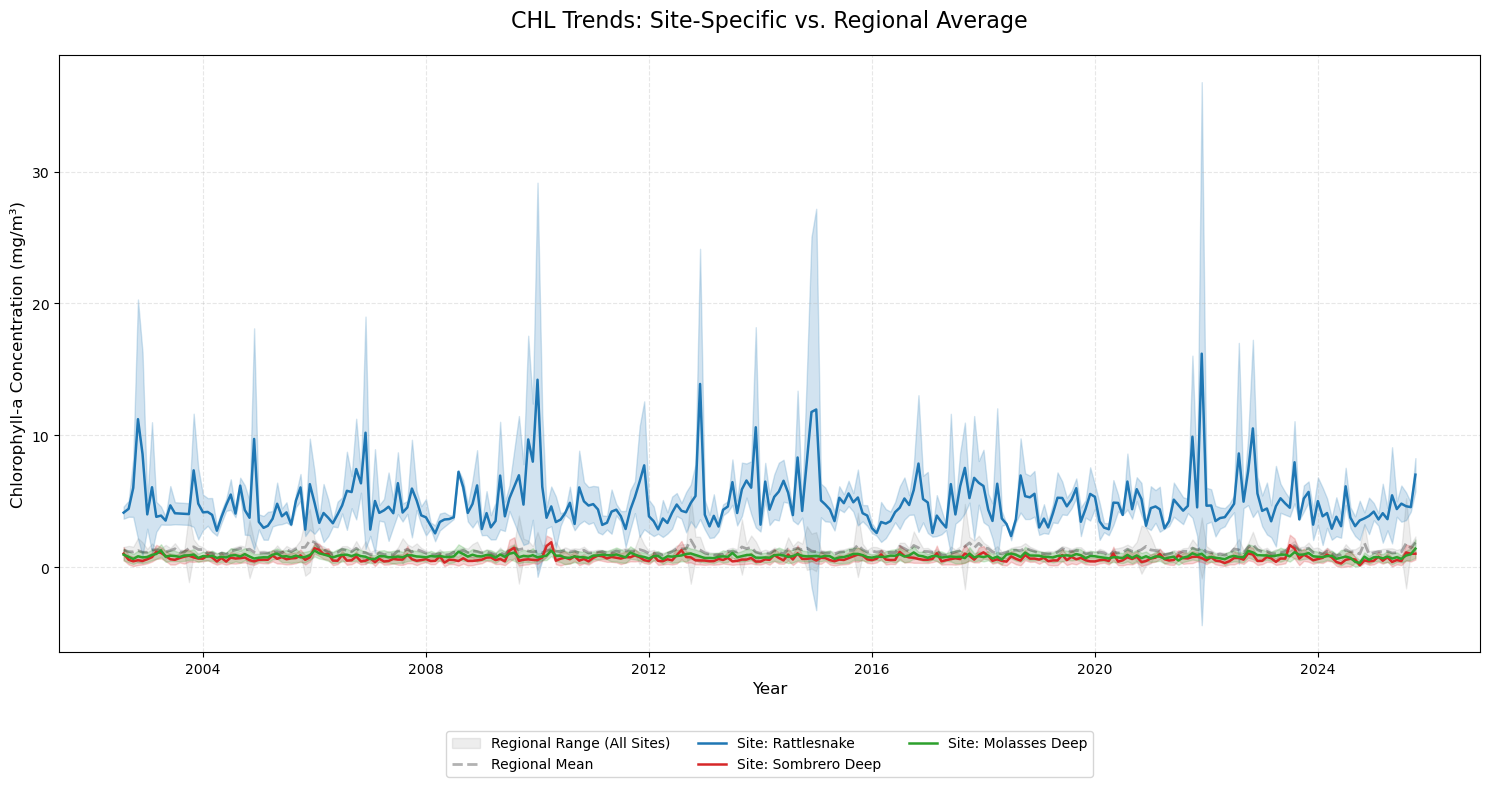

In [6]:
warnings.filterwarnings('ignore', message='Degrees of freedom <= 0 for slice')

# Load station metadata
df_stations = pd.read_csv(os.path.join("~/multitressor/", "survey_latlon_date.csv"))

# Select either ds_sst_daily or ds_sst_monthly as needed
ds_input = ds_chl_monthly 

# 1. Prepare unique site list
df_unique_sites = df_stations[['site_name', 'latitude', 'longitude']].drop_duplicates(subset='site_name')

# 2. Iteratively extract 3x3 pixel box for each site
site_chl_results = {}

for idx, row in df_unique_sites.iterrows():
    site = row['site_name']
    lat, lon = row['latitude'], row['longitude']
    
    # Find center indices
    center_ds = ds_input.sel(latitude=lat, longitude=lon, method='nearest')
    lat_idx = np.abs(ds_input.latitude - center_ds.latitude).argmin().item()
    lon_idx = np.abs(ds_input.longitude - center_ds.longitude).argmin().item()
    
    # Extract 3x3 grid
    subset = ds_input.chlor_a_median.isel(
        latitude=slice(lat_idx - 1, lat_idx + 2),
        longitude=slice(lon_idx - 1, lon_idx + 2)
    )
    
    # Calculate spatial mean for the 3x3 box
    site_mean = subset.mean(dim=['latitude', 'longitude'])
    site_std = subset.std(dim=['latitude', 'longitude'])
    
    # Convert to dataframe
    df_site = pd.DataFrame({
        'Date': site_mean.time.values,
        'CHL_Mean': site_mean.values,
        'CHL_SD': site_std.values
    }).dropna() # Drop any months with missing data
    
    df_site['site_name'] = site
    site_chl_results[site] = df_site

# Combine all sites
df_chl_master = pd.concat(site_chl_results.values(), ignore_index=True)

# 3. Plotting with Regional Reference
selected_sites = ['Rattlesnake', 'Sombrero Deep', 'Molasses Deep']
colors = {'Rattlesnake': '#1f77b4', 'Sombrero Deep': '#d62728', 'Molasses Deep': '#2ca02c'}

# Group by Date to get the regional average
regional_ref = df_chl_master.groupby('Date').agg({
    'CHL_Mean': 'mean',
    'CHL_SD': 'std'
}).reset_index()

plt.figure(figsize=(15, 8))

# Background Regional Reference
plt.fill_between(regional_ref['Date'], 
                 regional_ref['CHL_Mean'] - regional_ref['CHL_SD'], 
                 regional_ref['CHL_Mean'] + regional_ref['CHL_SD'], 
                 color='black', alpha=0.07, label='Regional Range (All Sites)')
plt.plot(regional_ref['Date'], regional_ref['CHL_Mean'], 
         color='black', linestyle='--', linewidth=2, alpha=0.3, label='Regional Mean')

# Plot Selected Sites
for site in selected_sites:
    plot_data = site_chl_results.get(site)
    if plot_data is not None:
        plt.fill_between(plot_data['Date'], 
                         plot_data['CHL_Mean'] - plot_data['CHL_SD'], 
                         plot_data['CHL_Mean'] + plot_data['CHL_SD'], 
                         color=colors[site], alpha=0.2)
        plt.plot(plot_data['Date'], plot_data['CHL_Mean'], 
                 color=colors[site], linewidth=1.8, label=f'Site: {site}')

# Formatting and Titles
plt.title(f'CHL Trends: Site-Specific vs. Regional Average', fontsize=16, pad=20)
plt.ylabel('Chlorophyll-a Concentration (mg/m³)', fontsize=12)
plt.xlabel('Year', fontsize=12)
# plt.ylim(18, 35) 
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3, frameon=True)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

#### Create a map showing the median CHL per site

In [ ]:
# --- 1. Calculate the overall median CHL for each site
df_site_medians = df_chl_master.groupby('site_name').agg({
    'CHL_Mean': 'median',
    'Date': 'count' # To ensure we have enough data points
}).reset_index().rename(columns={'CHL_Mean': 'Median_CHL'})

# Merge with site metadata (coords and region)
# Using df_unique_sites which we defined in the extraction cell
df_median_map = pd.merge(df_site_medians, df_unique_sites, on='site_name')

# Re-attach region metadata if missing
if 'region' not in df_median_map.columns:
    region_map = df_stations[['site_name', 'region']].drop_duplicates()
    df_median_map = pd.merge(df_median_map, region_map, on='site_name')

# Symbol Logic Mapping
marker_map = {'BC': 's', 'LK': '^', 'DT': 'v', 'DC': '*', 'MQ': 'D', 'MC': '<', 'PB': '>', 'MK': '+', 'UK': 'o'}

# --- 2. PLOTTING ---
fig = plt.figure(figsize=(16, 12))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([df_median_map['longitude'].min()-0.2, df_median_map['longitude'].max()+0.2, 
               df_median_map['latitude'].min()-0.2, df_median_map['latitude'].max()+0.2])

# Add Geographic Features
ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor='#d9d9d9')
ax.add_feature(cfeature.OCEAN.with_scale('10m'), facecolor='#eef7ff')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8)

# Define Color Normalization for Median CHL
# Chlorophyll often looks better with a slight padding on the max for color depth
vmin = df_median_map['Median_CHL'].min()
vmax = df_median_map['Median_CHL'].max()

# --- ITERATIVE PLOTTING BY REGION ---
sc = None
for reg, mkr in marker_map.items():
    reg_data = df_median_map[df_median_map['region'] == reg]
    if not reg_data.empty:
        sc = ax.scatter(reg_data['longitude'], reg_data['latitude'], 
                        c=reg_data['Median_CHL'], cmap='YlGnBu', marker=mkr,
                        s=220, edgecolor='black', linewidth=0.8, alpha=0.9,
                        zorder=3, transform=ccrs.PlateCarree(),
                        vmin=vmin, vmax=vmax)

# Add Labels for the sites with the highest median CHL (Potential Nutritent Hotspots)
top_chl_sites = df_median_map.nlargest(5, 'Median_CHL')
for i, row in top_chl_sites.iterrows():
    ax.text(row['longitude'] + 0.02, row['latitude'] + 0.01, row['site_name'],
             transform=ccrs.PlateCarree(), fontsize=9, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='navy', boxstyle='round,pad=0.2'),
             zorder=5)

# --- LEGENDS AND FORMATTING ---
# 1. Colorbar
if sc:
    cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', shrink=0.5, pad=0.08)
    cbar.set_label('Median Chlorophyll-a Concentration (mg/m³)', fontsize=12)

# 2. Region Legend
symbol_legend = [mlines.Line2D([0], [0], marker=m, color='w', label=k,
                               markerfacecolor='gray', markersize=10, markeredgecolor='k') 
                 for k, m in marker_map.items()]
ax.legend(handles=symbol_legend, loc='upper left', bbox_to_anchor=(1.02, 1), 
          title="Regions", frameon=True, fontsize=10)

ax.gridlines(draw_labels=True, linestyle='--', alpha=0.4).top_labels = False

plt.title('Median Monthly Chlorophyll-a (2002-2025)', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# --- 3. SUMMARY PRINT ---
print(f"Regional Median CHL Summary (mg/m³):")
display(df_median_map.groupby('region')['Median_CHL'].median().sort_values(ascending=False))

#### Create a box plot showing chl distributions per region

In [ ]:
# Set the visual theme
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 7))

# 1. Create the boxplot showing the distribution of site-level medians within each region
# We use 'YlGnBu' to stay consistent with the CHL color scheme
ax = sns.boxplot(
    data=df_median_map, 
    x='region', 
    y='Median_CHL', 
    palette='YlGnBu', 
    showfliers=False, 
    width=0.6
)

# 2. Overlay individual site medians as points (stripplot) 
# This helps see the number of sites (sample size) per region
sns.stripplot(
    data=df_median_map, 
    x='region', 
    y='Median_CHL', 
    color='black', 
    alpha=0.4, 
    jitter=True,
    size=7
)

# 3. Add a horizontal line representing the overall network median for context
network_median_chl = df_median_map['Median_CHL'].median()
plt.axhline(network_median_chl, color='navy', linestyle='--', linewidth=1.5, 
            label=f'Network Median: {network_median_chl:.3f} $mg/m^3$')

# 4. Titles and Labels
plt.title('Median Chlorophyll-a Concentrations per Region (2002-2025)', 
          fontsize=16, fontweight='bold', pad=15)
plt.ylabel('Median CHL ($mg/m^3$)', fontsize=13)
plt.xlabel('Region', fontsize=13)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# 5. Output descriptive statistics for the report
print("Median CHL ($mg/m^3$) per Region")
display(df_median_map.groupby('region')['Median_CHL'].describe().round(4))

#### Mann-Kendall on deseasonalized monthly CHL anomalies

In [ ]:
# 1. Initialize list to store results
mk_chl_results = []

print("Calculating Deseasonalized Monthly CHL Anomalies and MK Trends...")

# 2. Iterate through each site
for site_name, df_site in tqdm(site_chl_results.items()):
    
    # Create a copy and ensure Date is datetime
    df = df_site.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    
    # A. Resample to Monthly Mean (ensuring MS frequency)
    df_monthly = df['CHL_Mean'].resample('MS').mean().to_frame()
    
    # B. Calculate Climatology (Average for each month 1-12)
    df_monthly['Month'] = df_monthly.index.month
    climatology = df_monthly.groupby('Month')['CHL_Mean'].mean()
    
    # C. Subtract Climatology to get Anomaly
    df_monthly['Anomaly'] = df_monthly['CHL_Mean'] - df_monthly['Month'].map(climatology)
    
    # D. Perform Mann-Kendall on the Anomaly
    data = df_monthly['Anomaly'].dropna().values
    
    if len(data) > 24: # Require at least 2 years of data
        res = mk.original_test(data)
        
        # E. Convert Slope to Decadal
        # Slope is (mg/m³)/month -> *12 (Annual) *10 (Decadal)
        slope_per_decade = res.slope * 12 * 10
        
        mk_chl_results.append({
            'SiteName': site_name,
            'Trend': res.trend,
            'P_Value': res.p,
            'Z_Value': res.z,
            'Slope_Decade': slope_per_decade,
            'Significant': 'Significant' if res.p <= 0.05 else 'Not Significant'
        })

# 3. Create Summary DataFrame
df_mk_chl_trends = pd.DataFrame(mk_chl_results)

print("\nCHL Anomaly Trend Summary (Change in mg/m³ per Decade):")
display(df_mk_chl_trends.sort_values('Slope_Decade', ascending=False).head(20))

sig_sites = df_mk_chl_trends[df_mk_chl_trends['Significant'] == 'Significant']
print(f"Found {len(sig_sites)} sites with significant CHL trends.")

#### CHL trends distribution and spatial hotspots

In [ ]:
# --- 1. DATA PREPARATION ---
df_sig_trends = df_mk_chl_trends[(df_mk_chl_trends['Significant'] == 'Significant') & (df_mk_chl_trends['Trend'] == 'increasing')].copy()

# Ensure df_coords has 'region' before merging (assuming df_stations was our source)
df_sig_coords = pd.merge(df_sig_trends, df_unique_sites, left_on='SiteName', right_on='site_name')

# Re-attach the 'region' info from the original station metadata if it's not in df_unique_sites
if 'region' not in df_sig_coords.columns:
    region_map = df_stations[['site_name', 'region']].drop_duplicates()
    df_sig_coords = pd.merge(df_sig_coords, region_map, on='site_name')

# Identify the 80th percentile threshold for CHL "hotspots" (areas with fastest increasing CHL)
slope_threshold = df_sig_trends['Slope_Decade'].quantile(0.8)
df_high_chl = df_sig_coords[df_sig_coords['Slope_Decade'] >= slope_threshold]

# Symbol Logic Mapping (Matching your provided region codes)
marker_map = {'BC': 's', 'LK': '^', 'DT': 'v', 'DC': '*', 'MQ': 'D', 'MC': '<', 'PB': '>', 'MK': '+', 'UK': 'o'}

# --- 2. PLOTTING THE MAP ---
fig = plt.figure(figsize=(16, 12)) 

ax2 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax2.set_extent([df_sig_coords['longitude'].min()-0.2, df_sig_coords['longitude'].max()+0.2, 
                df_sig_coords['latitude'].min()-0.2, df_sig_coords['latitude'].max()+0.2])

ax2.add_feature(cfeature.LAND.with_scale('10m'), facecolor='#d9d9d9')
ax2.add_feature(cfeature.OCEAN.with_scale('10m'), facecolor='#eef7ff')
ax2.add_feature(cfeature.COASTLINE.with_scale('10m'))

# Define normalization - Using 'YlGnBu' or 'Greens' is often better for Chlorophyll
vmin = df_sig_coords['Slope_Decade'].min()
vmax = df_sig_coords['Slope_Decade'].max()
cmap_chl = 'YlGnBu' 

# --- ITERATIVE PLOTTING BY REGION ---
sc = None
for sub, mkr in marker_map.items():
    sub_data = df_sig_coords[df_sig_coords['region'] == sub]
    if not sub_data.empty:
        sc = ax2.scatter(sub_data['longitude'], sub_data['latitude'], 
                         c=sub_data['Slope_Decade'], cmap=cmap_chl, marker=mkr,
                         s=200, edgecolor='black', linewidth=0.8, alpha=0.9,
                         zorder=3, transform=ccrs.PlateCarree(),
                         vmin=vmin, vmax=vmax)

# Add labels for the 80th percentile "Hotspots"
for i, row in df_high_chl.iterrows():
    ax2.text(row['longitude'] + 0.02, row['latitude'] + 0.01, row['site_name'],
             transform=ccrs.PlateCarree(), fontsize=9, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='green', boxstyle='round,pad=0.2'),
             zorder=5)

# --- LEGENDS AND FORMATTING ---
if sc:
    cbar = plt.colorbar(sc, ax=ax2, orientation='horizontal', shrink=0.5, pad=0.08)
    cbar.set_label('CHL Trend Rate (mg/m³ per decade)', fontsize=12)

symbol_legend = [mlines.Line2D([0], [0], marker=m, color='w', label=k,
                               markerfacecolor='gray', markersize=10, markeredgecolor='k') 
                 for k, m in marker_map.items()]
ax2.legend(handles=symbol_legend, loc='upper left', bbox_to_anchor=(1.02, 1), 
          title="Regions", frameon=True, fontsize=10)

ax2.set_title('Deseasonalized Chlorophyll-a Increasing Rates per Decade\n(80th percentile threshold; p < 0.05)', 
             fontsize=16, pad=20)

plt.tight_layout()
plt.show()

# --- 3. DISTRIBUTION ANALYSIS BY REGION ---

plt.figure(figsize=(12, 7))
sns.set_theme(style="whitegrid")

# Create the boxplot for CHL trends
ax_box = sns.boxplot(
    data=df_sig_coords, 
    x='region', 
    y='Slope_Decade', 
    palette='YlGnBu', 
    showfliers=False, 
    width=0.6
)

sns.stripplot(
    data=df_sig_coords, 
    x='region', 
    y='Slope_Decade', 
    color='black', 
    alpha=0.4, 
    jitter=True,
    size=6
)

# Network-wide median CHL trend
network_median_slope = df_sig_coords['Slope_Decade'].median()
plt.axhline(network_median_slope, color='green', linestyle='--', linewidth=1.5, 
            label=f'Network Median: {network_median_slope:.4f} mg/m³/dec')

plt.title('Increasing CHL Trends by Region', fontsize=16, fontweight='bold', pad=15)
plt.ylabel('CHL Trend (mg/m³ per decade)', fontsize=13)
plt.xlabel('Region', fontsize=13)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Print statistical summary
print("\nDescriptive Statistics for Decadal CHL Trends:")
display(df_sig_coords.groupby('region')['Slope_Decade'].describe().round(4))

#### Download monthly Rrs667 data. Skip this cell if data have already been downloaded

In [ ]:
# 1. Setup the URL and local filename
save_dest = "Rrs667_Monthly_Data_Subset.nc"

# Define Parameters (Matching your study area)
n_lat = 27.5
s_lat = 24.4
e_lon = -79.5
w_lon = -83
start_time = '2002-07-29T00:00:00Z'
end_time = '2025-09-30T00:00:00Z'

# 2. Construct the URL for the USF ERDDAP server
base_url = "https://erddap.marine.usf.edu/erddap/griddap/moda_oc_mo_gom.nc"

# Construction: parameter[(time)][(latitude)][(longitude)]
constraints = (
    f"Rrs_667_median[({start_time}):1:({end_time})][({s_lat}):1:({n_lat})][({w_lon}):1:({e_lon})]"
)

url = f"{base_url}?{constraints}"

print(f"Connecting to USF ERDDAP...")
print(f"Targeting: {url}")

try:
    # 3. Download the file 
    with requests.get(url, stream=True, timeout=1200) as r:
        r.raise_for_status()
        with open(save_dest, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    print(f"Rrs 667 file saved successfully as {save_dest}")

    # 4. Open with xarray
    # mask_and_scale=True handles the fill values automatically
    ds_rrs667_monthly = xr.open_dataset(save_dest, mask_and_scale=True)
    print("Rrs 667 data successfully loaded into xarray.")
    
    # Pre-process: Rename variables for clarity if needed
    display(ds_rrs667_monthly)
except requests.exceptions.HTTPError as err:
    print(f"HTTP Error: {err}")
    print("Likely causes: Time range requested is before/after dataset availability, or coordinates are out of bounds.")
except Exception as e:
    print(f"An error occurred: {e}")

#### If Rrs667 data already downloaded, run this cell to load data

In [7]:
# Define paths to chl-a data 
path_rrs667_monthly = "/home/enrique.montes@CNS.local/multitressor/Rrs667_Monthly_Data_Subset.nc"

print("Checking for files...")
for p in [path_rrs667_monthly, path_rrs667_monthly]:
    if os.path.exists(p):
        print(f"  [OK] Found: {os.path.basename(p)}")
    else:
        print(f"  [MISSING] Could not find: {p}")

# Load the datasets
try:
    # We use chunks={} to enable dask-backed lazy loading for the large daily file
    ds_rrs667_monthly = xr.open_dataset(path_rrs667_monthly, chunks={'time': 500})
    print("\nMonthly Rrs667 loaded successfully.")
    
    ds_rrs667_monthly = xr.open_dataset(path_rrs667_monthly)
    print("Monthly Rrs667 Subset loaded successfully.")
    
    # Display the daily dataset to check time range and variables
    display(ds_rrs667_monthly)
except Exception as e:
    print(f"\nError loading datasets: {e}")

Checking for files...
  [OK] Found: Rrs667_Monthly_Data_Subset.nc
  [OK] Found: Rrs667_Monthly_Data_Subset.nc

Monthly Rrs667 loaded successfully.
Monthly Rrs667 Subset loaded successfully.


<xarray.Dataset> Size: 295MB
Dimensions:         (time: 279, latitude: 342, longitude: 387)
Coordinates:
  * time            (time) datetime64[ns] 2kB 2002-07-29 ... 2025-09-30
  * latitude        (latitude) float32 1kB 27.5 27.49 27.48 ... 24.42 24.41 24.4
  * longitude       (longitude) float32 2kB -83.0 -83.0 -82.99 ... -79.51 -79.5
Data variables:
    Rrs_667_median  (time, latitude, longitude) float64 295MB ...
Attributes: (12/45)
    cdm_data_type:                        Grid
    Composite_end_date:                   30-Sep-2025
    Composite_start_date:                 01-Sep-2025
    contact:                              Dan Otis - dotis@usf.edu
    Conventions:                          COARDS, CF-1.6, ACDD-1.3
    CreationDate:                         10/21/2025 20:16:04
    ...                                   ...
    summary:                              USF IMaRS MODIS GOM Monthly Mean Oc...
    time_coverage_end:                    2025-09-30T00:00:00Z
    time_coverage_start:                  2002-07-29T00:00:00Z
    Time_interval:                        Monthly Composite (median)
    title:                                MODIS-Aqua Ocean Color Monthly mean...
    Westernmost_Easting:                  -83.00438

#### Extract Rrs 667 for RLS stations

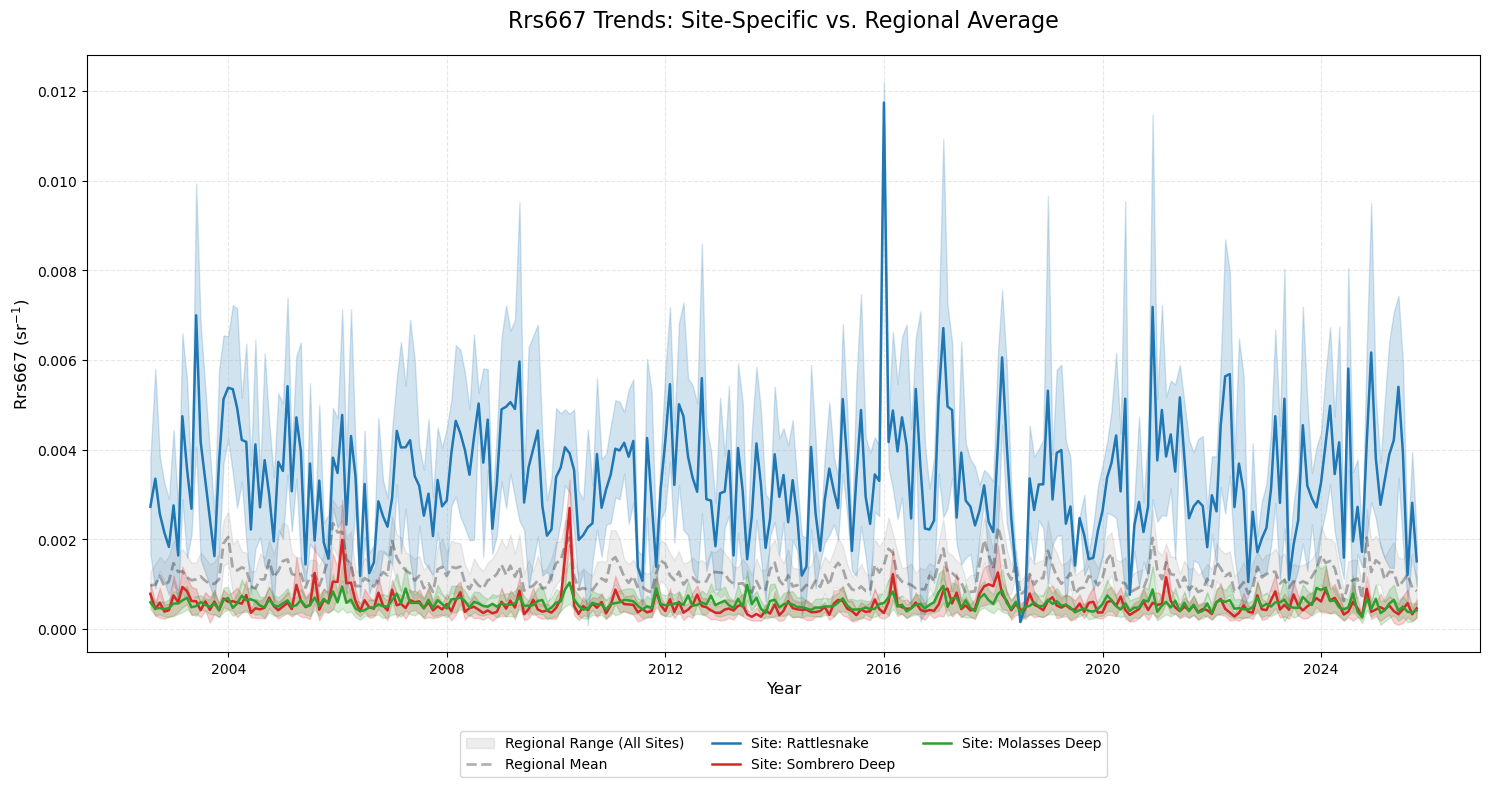

In [8]:
warnings.filterwarnings('ignore', message='Degrees of freedom <= 0 for slice')

# Load station metadata
df_stations = pd.read_csv(os.path.join("~/multitressor/", "survey_latlon_date.csv"))

# Select either ds_sst_daily or ds_sst_monthly as needed
ds_input = ds_rrs667_monthly 

# 1. Prepare unique site list
df_unique_sites = df_stations[['site_name', 'latitude', 'longitude']].drop_duplicates(subset='site_name')

# 2. Iteratively extract 3x3 pixel box for each site
site_rrs667_results = {}

for idx, row in df_unique_sites.iterrows():
    site = row['site_name']
    lat, lon = row['latitude'], row['longitude']
    
    # Find center indices
    center_ds = ds_input.sel(latitude=lat, longitude=lon, method='nearest')
    lat_idx = np.abs(ds_input.latitude - center_ds.latitude).argmin().item()
    lon_idx = np.abs(ds_input.longitude - center_ds.longitude).argmin().item()
    
    # Extract 3x3 grid
    subset = ds_input.Rrs_667_median.isel(
        latitude=slice(lat_idx - 1, lat_idx + 2),
        longitude=slice(lon_idx - 1, lon_idx + 2)
    )
    
    # Calculate spatial mean for the 3x3 box
    site_mean = subset.mean(dim=['latitude', 'longitude'])
    site_std = subset.std(dim=['latitude', 'longitude'])
    
    # Convert to dataframe
    df_site = pd.DataFrame({
        'Date': site_mean.time.values,
        'Rrs667_Mean': site_mean.values,
        'Rrs667_SD': site_std.values
    }).dropna() # Drop any months with missing data
    
    df_site['site_name'] = site
    site_rrs667_results[site] = df_site

# Combine all sites
df_rrs667_master = pd.concat(site_rrs667_results.values(), ignore_index=True)

# 3. Plotting with Regional Reference
selected_sites = ['Rattlesnake', 'Sombrero Deep', 'Molasses Deep']
colors = {'Rattlesnake': '#1f77b4', 'Sombrero Deep': '#d62728', 'Molasses Deep': '#2ca02c'}

# Group by Date to get the regional average
regional_ref = df_rrs667_master.groupby('Date').agg({
    'Rrs667_Mean': 'mean',
    'Rrs667_SD': 'std'
}).reset_index()

plt.figure(figsize=(15, 8))

# Background Regional Reference
plt.fill_between(regional_ref['Date'], 
                 regional_ref['Rrs667_Mean'] - regional_ref['Rrs667_SD'], 
                 regional_ref['Rrs667_Mean'] + regional_ref['Rrs667_SD'], 
                 color='black', alpha=0.07, label='Regional Range (All Sites)')
plt.plot(regional_ref['Date'], regional_ref['Rrs667_Mean'], 
         color='black', linestyle='--', linewidth=2, alpha=0.3, label='Regional Mean')

# Plot Selected Sites
for site in selected_sites:
    plot_data = site_rrs667_results.get(site)
    if plot_data is not None:
        plt.fill_between(plot_data['Date'], 
                         plot_data['Rrs667_Mean'] - plot_data['Rrs667_SD'], 
                         plot_data['Rrs667_Mean'] + plot_data['Rrs667_SD'], 
                         color=colors[site], alpha=0.2)
        plt.plot(plot_data['Date'], plot_data['Rrs667_Mean'], 
                 color=colors[site], linewidth=1.8, label=f'Site: {site}')

# Formatting and Titles
plt.title(f'Rrs667 Trends: Site-Specific vs. Regional Average', fontsize=16, pad=20)
plt.ylabel('Rrs667 (sr$^{-1}$)', fontsize=12)
plt.xlabel('Year', fontsize=12)
# plt.ylim(18, 35) 
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3, frameon=True)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

#### Create a map showing the median Rrs @ 667nm per site

In [ ]:
# --- 1. Calculate the overall median Rrs667 for each site
df_site_medians = df_rrs667_master.groupby('site_name').agg({
    'Rrs667_Mean': 'median',
    'Date': 'count' # To ensure we have enough data points
}).reset_index().rename(columns={'Rrs667_Mean': 'Median_Rrs667'})

# Merge with site metadata (coords and region)
# Using df_unique_sites which we defined in the extraction cell
df_median_map = pd.merge(df_site_medians, df_unique_sites, on='site_name')

# Re-attach region metadata if missing
if 'region' not in df_median_map.columns:
    region_map = df_stations[['site_name', 'region']].drop_duplicates()
    df_median_map = pd.merge(df_median_map, region_map, on='site_name')

# Symbol Logic Mapping
marker_map = {'BC': 's', 'LK': '^', 'DT': 'v', 'DC': '*', 'MQ': 'D', 'MC': '<', 'PB': '>', 'MK': '+', 'UK': 'o'}

# --- 2. PLOTTING ---
fig = plt.figure(figsize=(16, 12))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([df_median_map['longitude'].min()-0.2, df_median_map['longitude'].max()+0.2, 
               df_median_map['latitude'].min()-0.2, df_median_map['latitude'].max()+0.2])

# Add Geographic Features
ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor='#d9d9d9')
ax.add_feature(cfeature.OCEAN.with_scale('10m'), facecolor='#eef7ff')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8)

# Define Color Normalization for Median Rrs667
# Rrs667 often looks better with a slight padding on the max for color depth
vmin = df_median_map['Median_Rrs667'].min()
vmax = df_median_map['Median_Rrs667'].max()

# --- ITERATIVE PLOTTING BY REGION ---
sc = None
for reg, mkr in marker_map.items():
    reg_data = df_median_map[df_median_map['region'] == reg]
    if not reg_data.empty:
        sc = ax.scatter(reg_data['longitude'], reg_data['latitude'], 
                        c=reg_data['Median_Rrs667'], cmap='YlGnBu', marker=mkr,
                        s=220, edgecolor='black', linewidth=0.8, alpha=0.9,
                        zorder=3, transform=ccrs.PlateCarree(),
                        vmin=vmin, vmax=vmax)

# Add Labels for the sites with the highest median Rrs667 (Potential Nutritent Hotspots)
top_rrs667_sites = df_median_map.nlargest(5, 'Median_Rrs667')
for i, row in top_rrs667_sites.iterrows():
    ax.text(row['longitude'] + 0.02, row['latitude'] + 0.01, row['site_name'],
             transform=ccrs.PlateCarree(), fontsize=9, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='navy', boxstyle='round,pad=0.2'),
             zorder=5)

# --- LEGENDS AND FORMATTING ---
# 1. Colorbar
if sc:
    cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', shrink=0.5, pad=0.08)
    cbar.set_label('Median Rrs667 (sr$^{-1}$)', fontsize=12)

# 2. Region Legend
symbol_legend = [mlines.Line2D([0], [0], marker=m, color='w', label=k,
                               markerfacecolor='gray', markersize=10, markeredgecolor='k') 
                 for k, m in marker_map.items()]
ax.legend(handles=symbol_legend, loc='upper left', bbox_to_anchor=(1.02, 1), 
          title="Regions", frameon=True, fontsize=10)

ax.gridlines(draw_labels=True, linestyle='--', alpha=0.4).top_labels = False

plt.title('Median Monthly Rrs @ 667 nm (2002-2025)', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# --- 3. SUMMARY PRINT ---
print(f"Regional Median Rrs667 Summary (sr$^{-1}$):")
display(df_median_map.groupby('region')['Median_Rrs667'].median().sort_values(ascending=False))

#### Create a box plot showing distributions of Rrs @ 667nm per region

In [ ]:
# Set the visual theme
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 7))

# 1. Create the boxplot showing the distribution of site-level medians within each region
# We use 'YlGnBu' to stay consistent with the Rrs color scheme
ax = sns.boxplot(
    data=df_median_map, 
    x='region', 
    y='Median_Rrs667', 
    palette='YlGnBu', 
    showfliers=False, 
    width=0.6
)

# 2. Overlay individual site medians as points (stripplot) 
# This helps see the number of sites (sample size) per region
sns.stripplot(
    data=df_median_map, 
    x='region', 
    y='Median_Rrs667', 
    color='black', 
    alpha=0.4, 
    jitter=True,
    size=7
)

# 3. Add a horizontal line representing the overall network median for context
network_median_rrs667 = df_median_map['Median_Rrs667'].median()
plt.axhline(network_median_rrs667, color='navy', linestyle='--', linewidth=1.5, 
            label=f'Network Median: {network_median_rrs667:.3f} sr$^{-1}$')

# 4. Titles and Labels
plt.title('Median Rrs @ 667 nm per Region (2002-2025)', 
          fontsize=16, fontweight='bold', pad=15)
plt.ylabel('Median Rrs667 (sr$^{-1}$)', fontsize=13)
plt.xlabel('Region', fontsize=13)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# 5. Output descriptive statistics for the report
print("Median Rrs667 (sr$^{-1}$) per Region")
display(df_median_map.groupby('region')['Median_Rrs667'].describe().round(4))

#### Mann-Kendall on deseasonalized Rrs 667 data

In [ ]:
# 1. Initialize list to store results
mk_rrs667_results = []

print("Calculating Deseasonalized Monthly Rrs667 Anomalies and MK Trends...")

# 2. Iterate through each site
for site_name, df_site in tqdm(site_rrs667_results.items()):
    
    # Create a copy and ensure Date is datetime
    df = df_site.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    
    # A. Resample to Monthly Mean (ensuring MS frequency)
    df_monthly = df['Rrs667_Mean'].resample('MS').mean().to_frame()
    
    # B. Calculate Climatology (Average for each month 1-12)
    df_monthly['Month'] = df_monthly.index.month
    climatology = df_monthly.groupby('Month')['Rrs667_Mean'].mean()
    
    # C. Subtract Climatology to get Anomaly
    df_monthly['Anomaly'] = df_monthly['Rrs667_Mean'] - df_monthly['Month'].map(climatology)
    
    # D. Perform Mann-Kendall on the Anomaly
    data = df_monthly['Anomaly'].dropna().values
    
    if len(data) > 24: # Require at least 2 years of data
        res = mk.original_test(data)
        
        # E. Convert Slope to Decadal
        # Slope is (mg/m³)/month -> *12 (Annual) *10 (Decadal)
        slope_per_decade = res.slope * 12 * 10
        
        mk_rrs667_results.append({
            'SiteName': site_name,
            'Trend': res.trend,
            'P_Value': res.p,
            'Z_Value': res.z,
            'Slope_Decade': slope_per_decade,
            'Significant': 'Significant' if res.p <= 0.05 else 'Not Significant'
        })

# 3. Create Summary DataFrame
df_mk_rrs667_trends = pd.DataFrame(mk_rrs667_results)

print("\nRrs667 Anomaly Trend Summary (Change in sr$^{-1}$ per Decade):")
display(df_mk_rrs667_trends.sort_values('Slope_Decade', ascending=False).head(20))

sig_sites = df_mk_rrs667_trends[df_mk_rrs667_trends['Significant'] == 'Significant']
print(f"Found {len(sig_sites)} sites with significant Rrs667 trends.")

#### Rrs 667 trend distribution and spatial hotspots

In [ ]:
# --- 1. DATA PREPARATION ---
df_sig_trends = df_mk_rrs667_trends[(df_mk_rrs667_trends['Significant'] == 'Significant') & (df_mk_rrs667_trends['Trend'] == 'increasing')].copy()

# Ensure df_coords has 'region' before merging (assuming df_stations was our source)
df_sig_coords = pd.merge(df_sig_trends, df_unique_sites, left_on='SiteName', right_on='site_name')

# Re-attach the 'region' info from the original station metadata if it's not in df_unique_sites
if 'region' not in df_sig_coords.columns:
    region_map = df_stations[['site_name', 'region']].drop_duplicates()
    df_sig_coords = pd.merge(df_sig_coords, region_map, on='site_name')

# Identify the 80th percentile threshold for Rrs667 "hotspots" (areas with fastest increasing Rrs667)
slope_threshold = df_sig_trends['Slope_Decade'].quantile(0.8)
df_high_rrs667 = df_sig_coords[df_sig_coords['Slope_Decade'] >= slope_threshold]

# Symbol Logic Mapping (Matching your provided region codes)
marker_map = {'BC': 's', 'LK': '^', 'DT': 'v', 'DC': '*', 'MQ': 'D', 'MC': '<', 'PB': '>', 'MK': '+', 'UK': 'o'}

# --- 2. PLOTTING THE MAP ---
fig = plt.figure(figsize=(16, 12)) 

ax2 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax2.set_extent([df_sig_coords['longitude'].min()-0.2, df_sig_coords['longitude'].max()+0.2, 
                df_sig_coords['latitude'].min()-0.2, df_sig_coords['latitude'].max()+0.2])

ax2.add_feature(cfeature.LAND.with_scale('10m'), facecolor='#d9d9d9')
ax2.add_feature(cfeature.OCEAN.with_scale('10m'), facecolor='#eef7ff')
ax2.add_feature(cfeature.COASTLINE.with_scale('10m'))

# Define normalization - Using 'YlGnBu' or 'Greens' is often better for Chlorophyll
vmin = df_sig_coords['Slope_Decade'].min()
vmax = df_sig_coords['Slope_Decade'].max()
cmap_rrs667 = 'YlGnBu' 

# --- ITERATIVE PLOTTING BY REGION ---
sc = None
for sub, mkr in marker_map.items():
    sub_data = df_sig_coords[df_sig_coords['region'] == sub]
    if not sub_data.empty:
        sc = ax2.scatter(sub_data['longitude'], sub_data['latitude'], 
                         c=sub_data['Slope_Decade'], cmap=cmap_rrs667, marker=mkr,
                         s=200, edgecolor='black', linewidth=0.8, alpha=0.9,
                         zorder=3, transform=ccrs.PlateCarree(),
                         vmin=vmin, vmax=vmax)

# Add labels for the 80th percentile "Hotspots"
for i, row in df_high_rrs667.iterrows():
    ax2.text(row['longitude'] + 0.02, row['latitude'] + 0.01, row['site_name'],
             transform=ccrs.PlateCarree(), fontsize=9, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='green', boxstyle='round,pad=0.2'),
             zorder=5)

# --- LEGENDS AND FORMATTING ---
if sc:
    cbar = plt.colorbar(sc, ax=ax2, orientation='horizontal', shrink=0.5, pad=0.08)
    cbar.set_label('Rrs667 Trend Rate (sr$^{-1}$ per decade)', fontsize=12)

symbol_legend = [mlines.Line2D([0], [0], marker=m, color='w', label=k,
                               markerfacecolor='gray', markersize=10, markeredgecolor='k') 
                 for k, m in marker_map.items()]
ax2.legend(handles=symbol_legend, loc='upper left', bbox_to_anchor=(1.02, 1), 
          title="Regions", frameon=True, fontsize=10)

ax2.set_title('Deseasonalized Rrs667 Increasing Rates per Decade\n(80th percentile threshold; p < 0.05)', 
             fontsize=16, pad=20)

plt.tight_layout()
plt.show()

# --- 3. DISTRIBUTION ANALYSIS BY REGION ---

plt.figure(figsize=(12, 7))
sns.set_theme(style="whitegrid")

# Create the boxplot for Rrs667 trends
ax_box = sns.boxplot(
    data=df_sig_coords, 
    x='region', 
    y='Slope_Decade', 
    palette='YlGnBu', 
    showfliers=False, 
    width=0.6
)

sns.stripplot(
    data=df_sig_coords, 
    x='region', 
    y='Slope_Decade', 
    color='black', 
    alpha=0.4, 
    jitter=True,
    size=6
)

# Network-wide median CHL trend
network_median_slope = df_sig_coords['Slope_Decade'].median()
plt.axhline(network_median_slope, color='green', linestyle='--', linewidth=1.5, 
            label=f'Network Median: {network_median_slope:.4f} sr$^{-1}$/dec')

plt.title('Increasing Rrs667 Trends by Region', fontsize=16, fontweight='bold', pad=15)
plt.ylabel('Rrs667 Trend (sr$^{-1}$ per decade)', fontsize=13)
plt.xlabel('Region', fontsize=13)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Print statistical summary
print("\nDescriptive Statistics for Decadal Rrs667 Trends:")
display(df_sig_coords.groupby('region')['Slope_Decade'].describe().round(4))

#### Download monthly Kd490 data. Skip this cell if data have already been downloaded

In [2]:
# 1. Setup the URL and local filename
save_dest = "Kd490_Monthly_Data_Subset.nc"

# Define Parameters (Matching your study area)
n_lat = 27.5
s_lat = 24.4
e_lon = -79.5
w_lon = -83
start_time = '2002-07-29T00:00:00Z'
end_time = '2025-09-30T00:00:00Z'

# 2. Construct the URL for the USF ERDDAP server
base_url = "https://erddap.marine.usf.edu/erddap/griddap/moda_oc_mo_gom.nc"

# Construction: parameter[(time)][(latitude)][(longitude)]
constraints = (
    f"Kd_490_median[({start_time}):1:({end_time})][({s_lat}):1:({n_lat})][({w_lon}):1:({e_lon})]"
)

url = f"{base_url}?{constraints}"

print(f"Connecting to USF ERDDAP...")
print(f"Targeting: {url}")

try:
    # 3. Download the file 
    with requests.get(url, stream=True, timeout=1200) as r:
        r.raise_for_status()
        with open(save_dest, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    print(f"Kd 490 file saved successfully as {save_dest}")

    # 4. Open with xarray
    # mask_and_scale=True handles the fill values automatically
    ds_kd490_monthly = xr.open_dataset(save_dest, mask_and_scale=True)
    print("Kd 490 data successfully loaded into xarray.")
    
    # Pre-process: Rename variables for clarity if needed
    display(ds_kd490_monthly)
except requests.exceptions.HTTPError as err:
    print(f"HTTP Error: {err}")
    print("Likely causes: Time range requested is before/after dataset availability, or coordinates are out of bounds.")
except Exception as e:
    print(f"An error occurred: {e}")

Connecting to USF ERDDAP...
Targeting: https://erddap.marine.usf.edu/erddap/griddap/moda_oc_mo_gom.nc?Kd_490_median[(2002-07-29T00:00:00Z):1:(2025-09-30T00:00:00Z)][(24.4):1:(27.5)][(-83):1:(-79.5)]
Kd 490 file saved successfully as Kd490_Monthly_Data_Subset.nc
Kd 490 data successfully loaded into xarray.


<xarray.Dataset> Size: 295MB
Dimensions:        (time: 279, latitude: 342, longitude: 387)
Coordinates:
  * time           (time) datetime64[ns] 2kB 2002-07-29 ... 2025-09-30
  * latitude       (latitude) float32 1kB 27.5 27.49 27.48 ... 24.42 24.41 24.4
  * longitude      (longitude) float32 2kB -83.0 -83.0 -82.99 ... -79.51 -79.5
Data variables:
    Kd_490_median  (time, latitude, longitude) float64 295MB ...
Attributes: (12/45)
    cdm_data_type:                        Grid
    Composite_end_date:                   30-Sep-2025
    Composite_start_date:                 01-Sep-2025
    contact:                              Dan Otis - dotis@usf.edu
    Conventions:                          COARDS, CF-1.6, ACDD-1.3
    CreationDate:                         10/21/2025 20:16:04
    ...                                   ...
    summary:                              USF IMaRS MODIS GOM Monthly Mean Oc...
    time_coverage_end:                    2025-09-30T00:00:00Z
    time_coverage_start:                  2002-07-29T00:00:00Z
    Time_interval:                        Monthly Composite (median)
    title:                                MODIS-Aqua Ocean Color Monthly mean...
    Westernmost_Easting:                  -83.00438

#### If Kd data already downloaded, run this cell to load data 

In [9]:
# Define paths to chl-a data 
path_kd490_monthly = "/home/enrique.montes@CNS.local/multitressor/Kd490_Monthly_Data_Subset.nc"

print("Checking for files...")
for p in [path_kd490_monthly, path_kd490_monthly]:
    if os.path.exists(p):
        print(f"  [OK] Found: {os.path.basename(p)}")
    else:
        print(f"  [MISSING] Could not find: {p}")

# Load the datasets
try:
    # We use chunks={} to enable dask-backed lazy loading for the large daily file
    ds_kd490_monthly = xr.open_dataset(path_kd490_monthly, chunks={'time': 500})
    print("\nMonthly Kd490 loaded successfully.")
    
    ds_kd490_monthly = xr.open_dataset(path_kd490_monthly)
    print("Monthly Kd490 Subset loaded successfully.")
    
    # Display the daily dataset to check time range and variables
    display(ds_kd490_monthly)
except Exception as e:
    print(f"\nError loading datasets: {e}")

Checking for files...
  [OK] Found: Kd490_Monthly_Data_Subset.nc
  [OK] Found: Kd490_Monthly_Data_Subset.nc

Monthly Kd490 loaded successfully.
Monthly Kd490 Subset loaded successfully.


<xarray.Dataset> Size: 295MB
Dimensions:        (time: 279, latitude: 342, longitude: 387)
Coordinates:
  * time           (time) datetime64[ns] 2kB 2002-07-29 ... 2025-09-30
  * latitude       (latitude) float32 1kB 27.5 27.49 27.48 ... 24.42 24.41 24.4
  * longitude      (longitude) float32 2kB -83.0 -83.0 -82.99 ... -79.51 -79.5
Data variables:
    Kd_490_median  (time, latitude, longitude) float64 295MB ...
Attributes: (12/45)
    cdm_data_type:                        Grid
    Composite_end_date:                   30-Sep-2025
    Composite_start_date:                 01-Sep-2025
    contact:                              Dan Otis - dotis@usf.edu
    Conventions:                          COARDS, CF-1.6, ACDD-1.3
    CreationDate:                         10/21/2025 20:16:04
    ...                                   ...
    summary:                              USF IMaRS MODIS GOM Monthly Mean Oc...
    time_coverage_end:                    2025-09-30T00:00:00Z
    time_coverage_start:                  2002-07-29T00:00:00Z
    Time_interval:                        Monthly Composite (median)
    title:                                MODIS-Aqua Ocean Color Monthly mean...
    Westernmost_Easting:                  -83.00438

#### Extract Kd490 from RLS sites

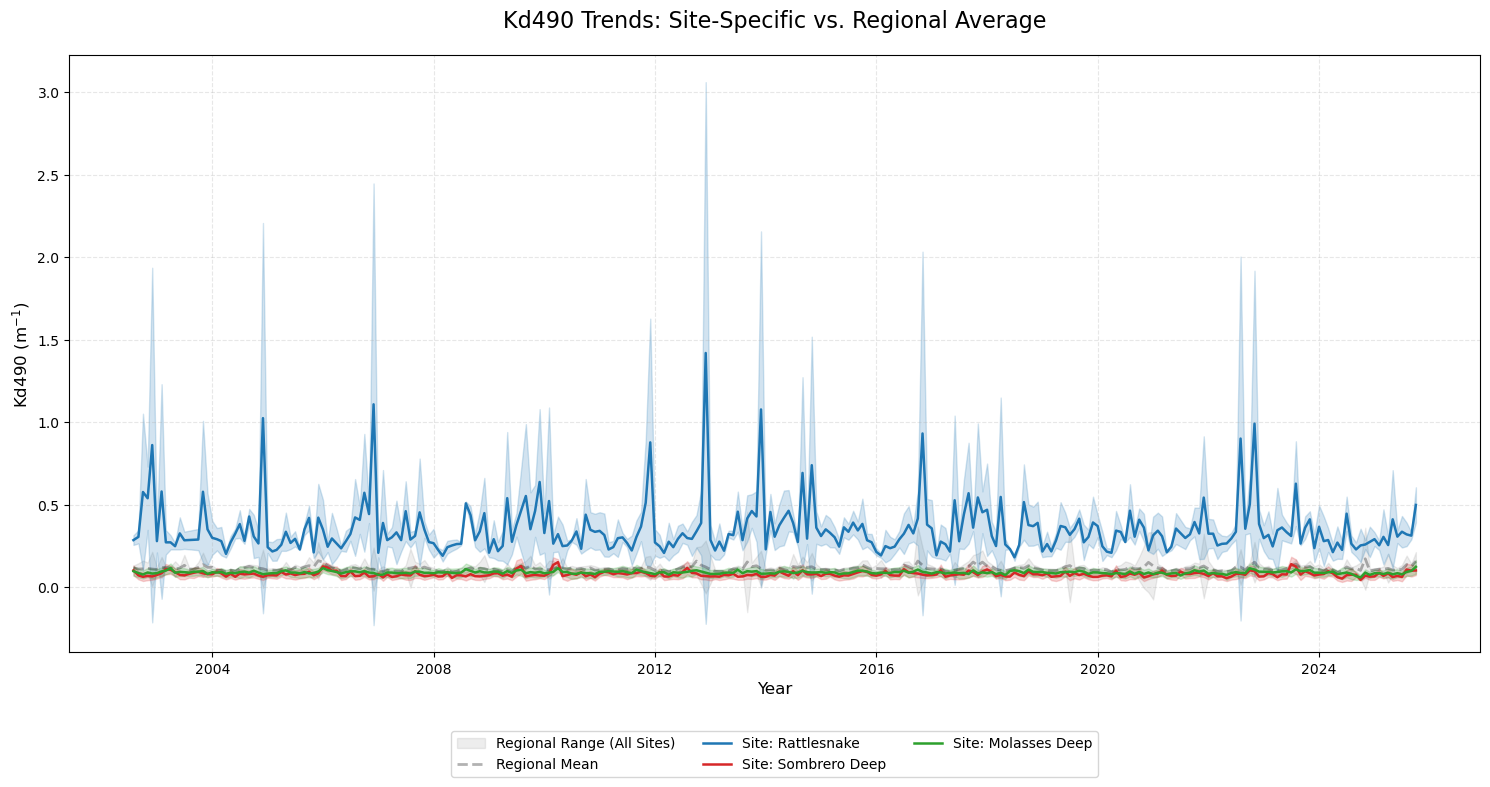

In [10]:
warnings.filterwarnings('ignore', message='Degrees of freedom <= 0 for slice')

# Load station metadata
df_stations = pd.read_csv(os.path.join("~/multitressor/", "survey_latlon_date.csv"))

# Select either ds_sst_daily or ds_sst_monthly as needed
ds_input = ds_kd490_monthly 

# 1. Prepare unique site list
df_unique_sites = df_stations[['site_name', 'latitude', 'longitude']].drop_duplicates(subset='site_name')

# 2. Iteratively extract 3x3 pixel box for each site
site_kd490_results = {}

for idx, row in df_unique_sites.iterrows():
    site = row['site_name']
    lat, lon = row['latitude'], row['longitude']
    
    # Find center indices
    center_ds = ds_input.sel(latitude=lat, longitude=lon, method='nearest')
    lat_idx = np.abs(ds_input.latitude - center_ds.latitude).argmin().item()
    lon_idx = np.abs(ds_input.longitude - center_ds.longitude).argmin().item()
    
    # Extract 3x3 grid
    subset = ds_input.Kd_490_median.isel(
        latitude=slice(lat_idx - 1, lat_idx + 2),
        longitude=slice(lon_idx - 1, lon_idx + 2)
    )
    
    # Calculate spatial mean for the 3x3 box
    site_mean = subset.mean(dim=['latitude', 'longitude'])
    site_std = subset.std(dim=['latitude', 'longitude'])
    
    # Convert to dataframe
    df_site = pd.DataFrame({
        'Date': site_mean.time.values,
        'Kd490_Mean': site_mean.values,
        'Kd490_SD': site_std.values
    }).dropna() # Drop any months with missing data
    
    df_site['site_name'] = site
    site_kd490_results[site] = df_site

# Combine all sites
df_kd490_master = pd.concat(site_kd490_results.values(), ignore_index=True)

# 3. Plotting with Regional Reference
selected_sites = ['Rattlesnake', 'Sombrero Deep', 'Molasses Deep']
colors = {'Rattlesnake': '#1f77b4', 'Sombrero Deep': '#d62728', 'Molasses Deep': '#2ca02c'}

# Group by Date to get the regional average
regional_ref = df_kd490_master.groupby('Date').agg({
    'Kd490_Mean': 'mean',
    'Kd490_SD': 'std'
}).reset_index()

plt.figure(figsize=(15, 8))

# Background Regional Reference
plt.fill_between(regional_ref['Date'], 
                 regional_ref['Kd490_Mean'] - regional_ref['Kd490_SD'], 
                 regional_ref['Kd490_Mean'] + regional_ref['Kd490_SD'], 
                 color='black', alpha=0.07, label='Regional Range (All Sites)')
plt.plot(regional_ref['Date'], regional_ref['Kd490_Mean'], 
         color='black', linestyle='--', linewidth=2, alpha=0.3, label='Regional Mean')

# Plot Selected Sites
for site in selected_sites:
    plot_data = site_kd490_results.get(site)
    if plot_data is not None:
        plt.fill_between(plot_data['Date'], 
                         plot_data['Kd490_Mean'] - plot_data['Kd490_SD'], 
                         plot_data['Kd490_Mean'] + plot_data['Kd490_SD'], 
                         color=colors[site], alpha=0.2)
        plt.plot(plot_data['Date'], plot_data['Kd490_Mean'], 
                 color=colors[site], linewidth=1.8, label=f'Site: {site}')

# Formatting and Titles
plt.title(f'Kd490 Trends: Site-Specific vs. Regional Average', fontsize=16, pad=20)
plt.ylabel('Kd490 (m$^{-1}$)', fontsize=12)
plt.xlabel('Year', fontsize=12)
# plt.ylim(18, 35) 
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3, frameon=True)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

#### Create a map showing the Kd490 median per site

/home/enrique.montes@CNS.local/miniconda3/envs/corals/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1677: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  result = super().scatter(*args, **kwargs)


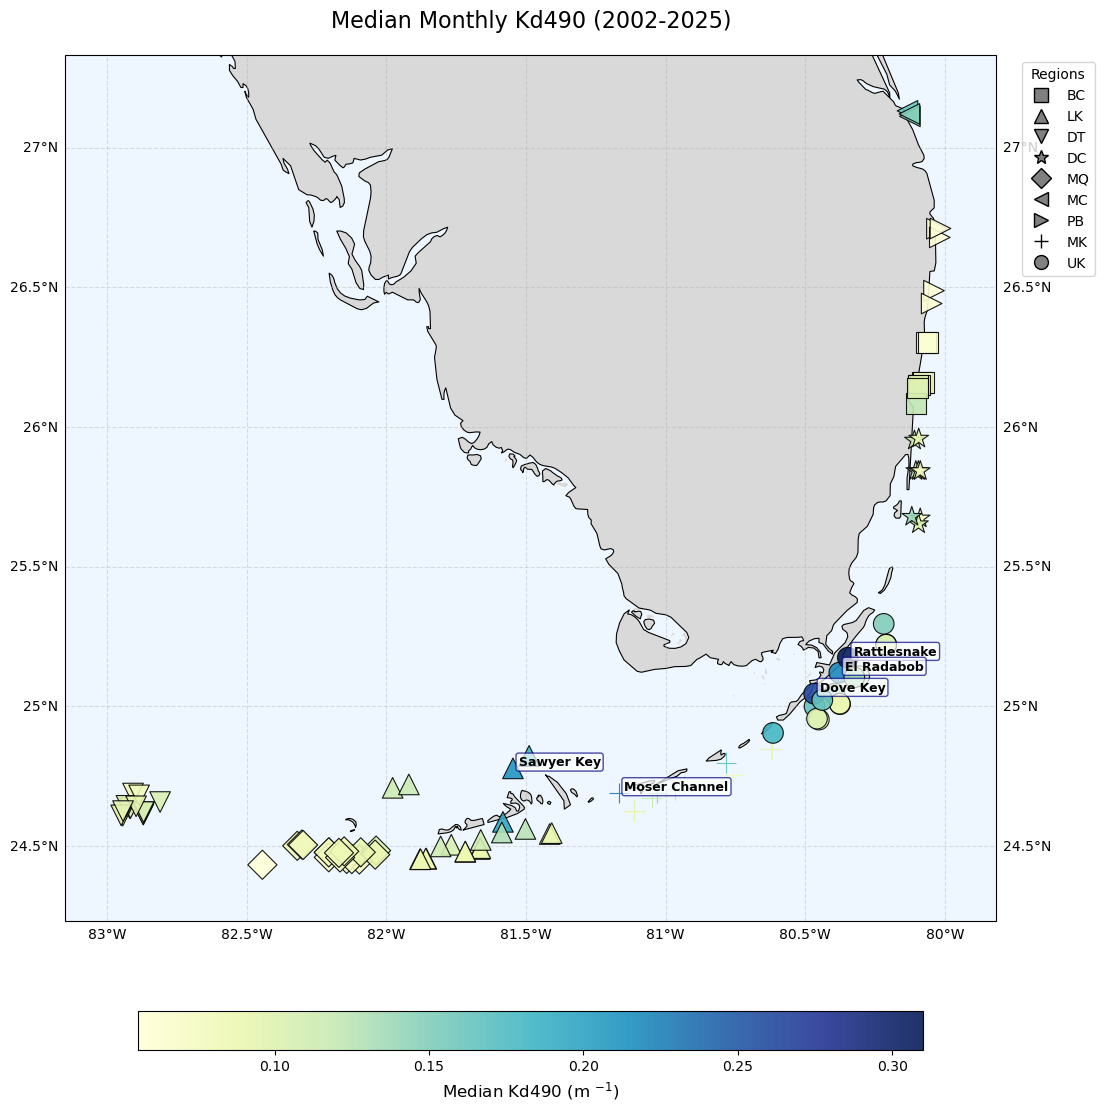

Regional Median Kd490 Summary (m$^-1$):


region
MC    0.151875
UK    0.143278
MK    0.108311
DC    0.099478
LK    0.097100
DT    0.095881
BC    0.086350
MQ    0.079189
PB    0.057718
Name: Median_Kd490, dtype: float64

In [8]:
# --- 1. Calculate the overall median Kd490 for each site
df_site_medians = df_kd490_master.groupby('site_name').agg({
    'Kd490_Mean': 'median',
    'Date': 'count' # To ensure we have enough data points
}).reset_index().rename(columns={'Kd490_Mean': 'Median_Kd490'})

# Merge with site metadata (coords and region)
# Using df_unique_sites which we defined in the extraction cell
df_median_map = pd.merge(df_site_medians, df_unique_sites, on='site_name')

# Re-attach region metadata if missing
if 'region' not in df_median_map.columns:
    region_map = df_stations[['site_name', 'region']].drop_duplicates()
    df_median_map = pd.merge(df_median_map, region_map, on='site_name')

# Symbol Logic Mapping
marker_map = {'BC': 's', 'LK': '^', 'DT': 'v', 'DC': '*', 'MQ': 'D', 'MC': '<', 'PB': '>', 'MK': '+', 'UK': 'o'}

# --- 2. PLOTTING ---
fig = plt.figure(figsize=(16, 12))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([df_median_map['longitude'].min()-0.2, df_median_map['longitude'].max()+0.2, 
               df_median_map['latitude'].min()-0.2, df_median_map['latitude'].max()+0.2])

# Add Geographic Features
ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor='#d9d9d9')
ax.add_feature(cfeature.OCEAN.with_scale('10m'), facecolor='#eef7ff')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8)

# Define Color Normalization for Median Kd490
# Kd490 often looks better with a slight padding on the max for color depth
vmin = df_median_map['Median_Kd490'].min()
vmax = df_median_map['Median_Kd490'].max()

# --- ITERATIVE PLOTTING BY REGION ---
sc = None
for reg, mkr in marker_map.items():
    reg_data = df_median_map[df_median_map['region'] == reg]
    if not reg_data.empty:
        sc = ax.scatter(reg_data['longitude'], reg_data['latitude'], 
                        c=reg_data['Median_Kd490'], cmap='YlGnBu', marker=mkr,
                        s=220, edgecolor='black', linewidth=0.8, alpha=0.9,
                        zorder=3, transform=ccrs.PlateCarree(),
                        vmin=vmin, vmax=vmax)

# Add Labels for the sites with the highest median Kd490 (Potential Nutritent Hotspots)
top_kd490_sites = df_median_map.nlargest(5, 'Median_Kd490')
for i, row in top_kd490_sites.iterrows():
    ax.text(row['longitude'] + 0.02, row['latitude'] + 0.01, row['site_name'],
             transform=ccrs.PlateCarree(), fontsize=9, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='navy', boxstyle='round,pad=0.2'),
             zorder=5)

# --- LEGENDS AND FORMATTING ---
# 1. Colorbar
if sc:
    cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', shrink=0.5, pad=0.08)
    cbar.set_label('Median Kd490 (m $^{-1}$)', fontsize=12)

# 2. Region Legend
symbol_legend = [mlines.Line2D([0], [0], marker=m, color='w', label=k,
                               markerfacecolor='gray', markersize=10, markeredgecolor='k') 
                 for k, m in marker_map.items()]
ax.legend(handles=symbol_legend, loc='upper left', bbox_to_anchor=(1.02, 1), 
          title="Regions", frameon=True, fontsize=10)

ax.gridlines(draw_labels=True, linestyle='--', alpha=0.4).top_labels = False

plt.title('Median Monthly Kd490 (2002-2025)', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# --- 3. SUMMARY PRINT ---
print(f"Regional Median Kd490 Summary (m$^{-1}$):")
display(df_median_map.groupby('region')['Median_Kd490'].median().sort_values(ascending=False))

#### Create a box plot showing distributions of Kd490 per region

/tmp/ipykernel_1488150/3451929164.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


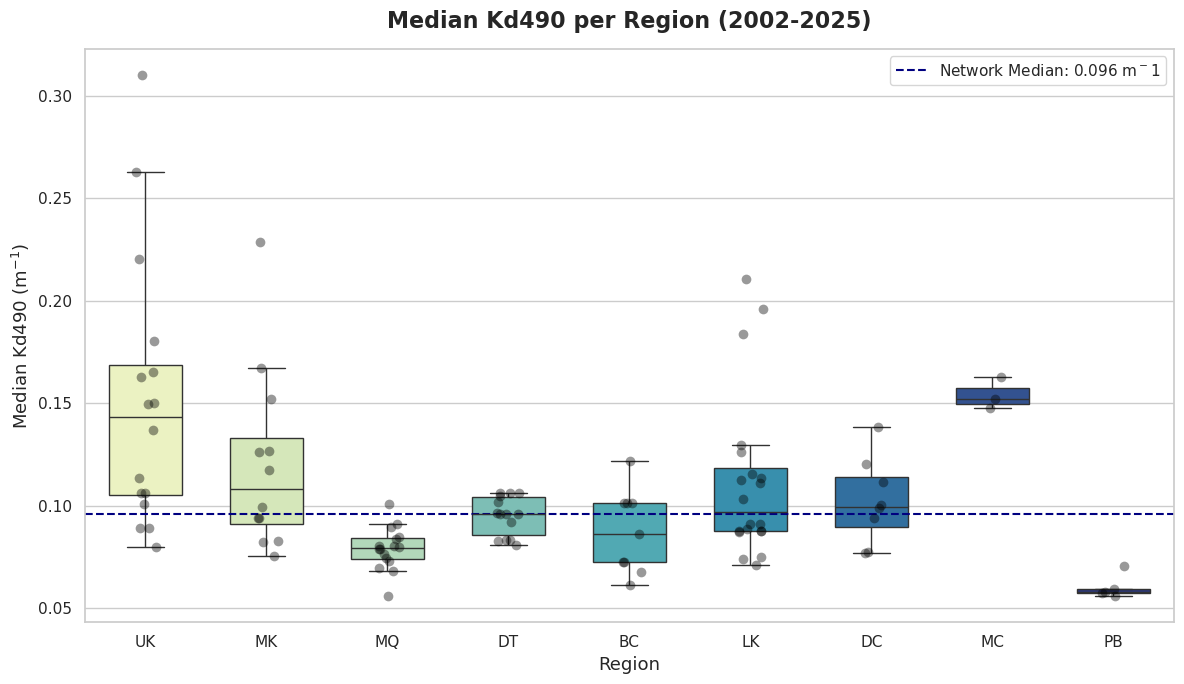

Median Kd490 (m$^{-1}$) per Region


,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
BC,9.0,0.0873,0.0203,0.0611,0.0725,0.0863,0.1014,0.1215
DC,8.0,0.1021,0.0210,0.0767,0.0897,0.0995,0.1138,0.1385
DT,14.0,0.0951,0.0095,0.0806,0.0855,0.0959,0.1041,0.1062
LK,20.0,0.1121,0.0403,0.0708,0.0877,0.0971,0.1183,0.2103
MC,3.0,0.1541,0.0078,0.1476,0.1497,0.1519,0.1573,0.1627
MK,12.0,0.1204,0.0445,0.0756,0.0911,0.1083,0.1328,0.2288
MQ,16.0,0.0790,0.0103,0.0558,0.0741,0.0792,0.0841,0.1007
PB,5.0,0.0602,0.0059,0.0559,0.0576,0.0577,0.0591,0.0706
UK,16.0,0.1514,0.0657,0.0800,0.1049,0.1433,0.1688,0.3101


In [9]:
# Set the visual theme
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 7))

# 1. Create the boxplot showing the distribution of site-level medians within each region
ax = sns.boxplot(
    data=df_median_map, 
    x='region', 
    y='Median_Kd490', 
    palette='YlGnBu', 
    showfliers=False, 
    width=0.6
)

# 2. Overlay individual site medians as points (stripplot) 
sns.stripplot(
    data=df_median_map, 
    x='region', 
    y='Median_Kd490', 
    color='black', 
    alpha=0.4, 
    jitter=True,
    size=7
)

# 3. Add a horizontal line representing the overall network median for context
network_median_kd490 = df_median_map['Median_Kd490'].median()
plt.axhline(network_median_kd490, color='navy', linestyle='--', linewidth=1.5, 
            label=f'Network Median: {network_median_kd490:.3f} m$^{-1}$')

# 4. Titles and Labels
plt.title('Median Kd490 per Region (2002-2025)', 
          fontsize=16, fontweight='bold', pad=15)
plt.ylabel('Median Kd490 (m$^{-1}$)', fontsize=13)
plt.xlabel('Region', fontsize=13)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# 5. Output descriptive statistics for the report
print("Median Kd490 (m$^{-1}$) per Region")
display(df_median_map.groupby('region')['Median_Kd490'].describe().round(4))

#### Mann-Kendall on deseasonalized kd490 data

In [11]:
# 1. Initialize list to store results
mk_kd490_results = []

print("Calculating Deseasonalized Monthly Kd490 Anomalies and MK Trends...")

# 2. Iterate through each site
for site_name, df_site in tqdm(site_kd490_results.items()):
    
    # Create a copy and ensure Date is datetime
    df = df_site.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    
    # A. Resample to Monthly Mean (ensuring MS frequency)
    df_monthly = df['Kd490_Mean'].resample('MS').mean().to_frame()
    
    # B. Calculate Climatology (Average for each month 1-12)
    df_monthly['Month'] = df_monthly.index.month
    climatology = df_monthly.groupby('Month')['Kd490_Mean'].mean()
    
    # C. Subtract Climatology to get Anomaly
    df_monthly['Anomaly'] = df_monthly['Kd490_Mean'] - df_monthly['Month'].map(climatology)
    
    # D. Perform Mann-Kendall on the Anomaly
    data = df_monthly['Anomaly'].dropna().values
    
    if len(data) > 24: # Require at least 2 years of data
        res = mk.original_test(data)
        
        # E. Convert Slope to Decadal
        # Slope is (mg/m³)/month -> *12 (Annual) *10 (Decadal)
        slope_per_decade = res.slope * 12 * 10
        
        mk_kd490_results.append({
            'SiteName': site_name,
            'Trend': res.trend,
            'P_Value': res.p,
            'Z_Value': res.z,
            'Slope_Decade': slope_per_decade,
            'Significant': 'Significant' if res.p <= 0.05 else 'Not Significant'
        })

# 3. Create Summary DataFrame
df_mk_kd490_trends = pd.DataFrame(mk_kd490_results)

print("\nKd490 Anomaly Trend Summary (Change in Kd490 per Decade):")
display(df_mk_kd490_trends.sort_values('Slope_Decade', ascending=False).head(20))

sig_sites = df_mk_kd490_trends[df_mk_kd490_trends['Significant'] == 'Significant']
print(f"Found {len(sig_sites)} sites with significant Kd490 trends.")

Calculating Deseasonalized Monthly Kd490 Anomalies and MK Trends...


100%|██████████| 105/105 [00:01<00:00, 82.30it/s]


Kd490 Anomaly Trend Summary (Change in Kd490 per Decade):


,SiteName,Trend,P_Value,Z_Value,Slope_Decade,Significant
97,Dove Key,increasing,1.730048e-04,3.755487,0.015644,Significant
102,Sawyer Key,increasing,1.373552e-10,6.418797,0.015084,Significant
100,Moser Channel,increasing,3.398627e-05,4.144967,0.012496,Significant
83,Content Keys,increasing,1.110708e-04,3.865040,0.009688,Significant
98,El Radabob,increasing,3.415103e-03,2.927672,0.007935,Significant
43,Jaap Reef,increasing,1.240383e-03,3.229428,0.007806,Significant
51,Lowe Shoal,increasing,5.647463e-06,4.539175,0.007495,Significant
52,Smith Shoal,increasing,1.125673e-05,4.391508,0.007231,Significant
58,Half Good,increasing,3.345248e-03,2.934092,0.004556,Significant
60,Ruby Oasis,increasing,4.039953e-03,2.875025,0.003783,Significant


Found 32 sites with significant Kd490 trends.


#### Kd490 trend distributions and spatial hotspots

/home/enrique.montes@CNS.local/miniconda3/envs/corals/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1677: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  result = super().scatter(*args, **kwargs)


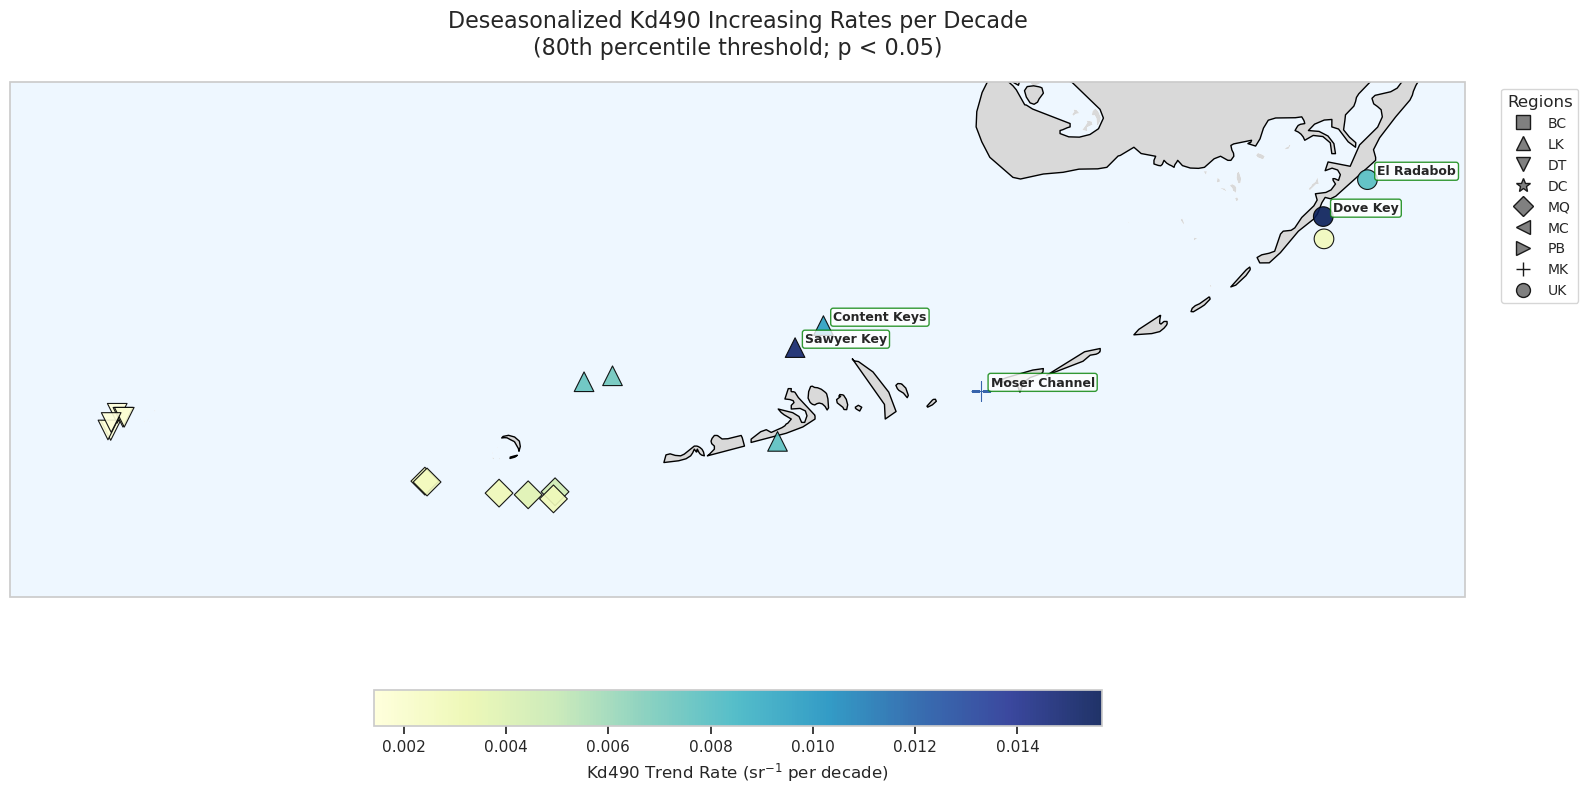

/tmp/ipykernel_1488150/305739824.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_box = sns.boxplot(


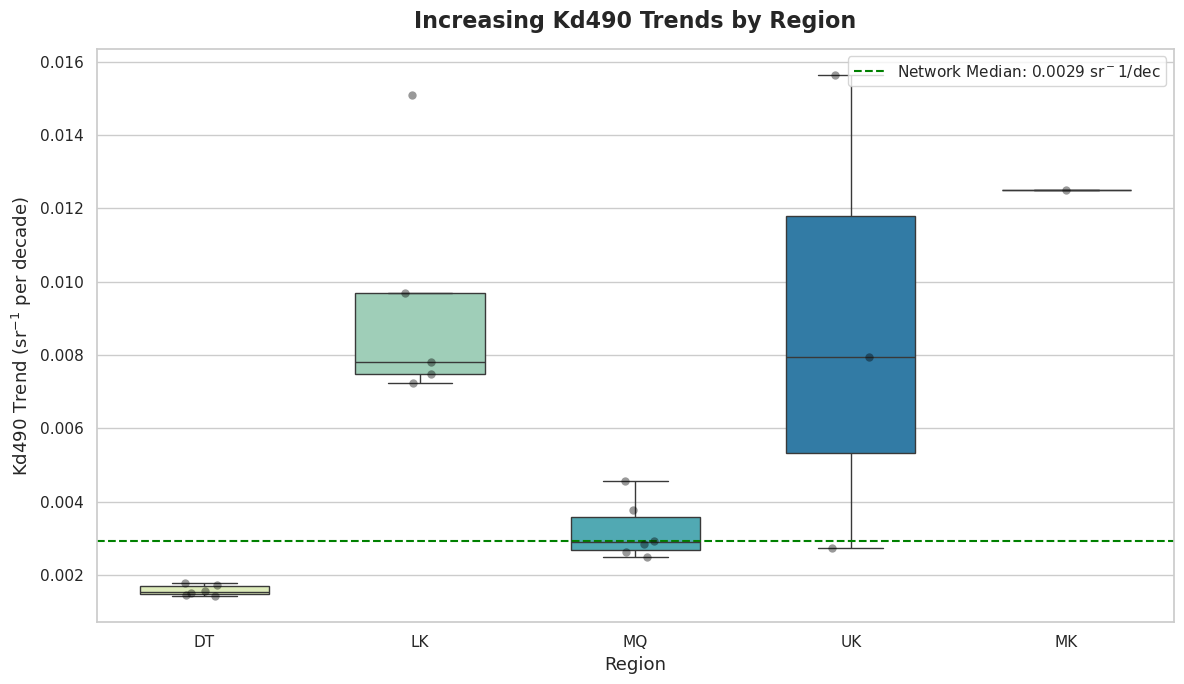


Descriptive Statistics for Decadal Kd490 Trends:


,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
DT,6.0,0.0016,0.0001,0.0014,0.0015,0.0015,0.0017,0.0018
LK,5.0,0.0095,0.0033,0.0072,0.0075,0.0078,0.0097,0.0151
MK,1.0,0.0125,NaN,0.0125,0.0125,0.0125,0.0125,0.0125
MQ,6.0,0.0032,0.0008,0.0025,0.0027,0.0029,0.0036,0.0046
UK,3.0,0.0088,0.0065,0.0027,0.0053,0.0079,0.0118,0.0156


In [12]:
# --- 1. DATA PREPARATION ---
df_sig_trends = df_mk_kd490_trends[(df_mk_kd490_trends['Significant'] == 'Significant') & (df_mk_kd490_trends['Trend'] == 'increasing')].copy()

# Ensure df_coords has 'region' before merging (assuming df_stations was our source)
df_sig_coords = pd.merge(df_sig_trends, df_unique_sites, left_on='SiteName', right_on='site_name')

# Re-attach the 'region' info from the original station metadata if it's not in df_unique_sites
if 'region' not in df_sig_coords.columns:
    region_map = df_stations[['site_name', 'region']].drop_duplicates()
    df_sig_coords = pd.merge(df_sig_coords, region_map, on='site_name')

# Identify the 80th percentile threshold for Kd490 "hotspots" (areas with fastest increasing Kd490)
slope_threshold = df_sig_trends['Slope_Decade'].quantile(0.8)
df_high_kd490 = df_sig_coords[df_sig_coords['Slope_Decade'] >= slope_threshold]

# Symbol Logic Mapping (Matching your provided region codes)
marker_map = {'BC': 's', 'LK': '^', 'DT': 'v', 'DC': '*', 'MQ': 'D', 'MC': '<', 'PB': '>', 'MK': '+', 'UK': 'o'}

# --- 2. PLOTTING THE MAP ---
fig = plt.figure(figsize=(16, 12)) 

ax2 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax2.set_extent([df_sig_coords['longitude'].min()-0.2, df_sig_coords['longitude'].max()+0.2, 
                df_sig_coords['latitude'].min()-0.2, df_sig_coords['latitude'].max()+0.2])

ax2.add_feature(cfeature.LAND.with_scale('10m'), facecolor='#d9d9d9')
ax2.add_feature(cfeature.OCEAN.with_scale('10m'), facecolor='#eef7ff')
ax2.add_feature(cfeature.COASTLINE.with_scale('10m'))

# Define normalization - Using 'YlGnBu' or 'Greens' is often better for Chlorophyll
vmin = df_sig_coords['Slope_Decade'].min()
vmax = df_sig_coords['Slope_Decade'].max()
cmap_kd490 = 'YlGnBu' 

# --- ITERATIVE PLOTTING BY REGION ---
sc = None
for sub, mkr in marker_map.items():
    sub_data = df_sig_coords[df_sig_coords['region'] == sub]
    if not sub_data.empty:
        sc = ax2.scatter(sub_data['longitude'], sub_data['latitude'], 
                         c=sub_data['Slope_Decade'], cmap=cmap_kd490, marker=mkr,
                         s=200, edgecolor='black', linewidth=0.8, alpha=0.9,
                         zorder=3, transform=ccrs.PlateCarree(),
                         vmin=vmin, vmax=vmax)

# Add labels for the 80th percentile "Hotspots"
for i, row in df_high_kd490.iterrows():
    ax2.text(row['longitude'] + 0.02, row['latitude'] + 0.01, row['site_name'],
             transform=ccrs.PlateCarree(), fontsize=9, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='green', boxstyle='round,pad=0.2'),
             zorder=5)

# --- LEGENDS AND FORMATTING ---
if sc:
    cbar = plt.colorbar(sc, ax=ax2, orientation='horizontal', shrink=0.5, pad=0.08)
    cbar.set_label('Kd490 Trend Rate (sr$^{-1}$ per decade)', fontsize=12)

symbol_legend = [mlines.Line2D([0], [0], marker=m, color='w', label=k,
                               markerfacecolor='gray', markersize=10, markeredgecolor='k') 
                 for k, m in marker_map.items()]
ax2.legend(handles=symbol_legend, loc='upper left', bbox_to_anchor=(1.02, 1), 
          title="Regions", frameon=True, fontsize=10)

ax2.set_title('Deseasonalized Kd490 Increasing Rates per Decade\n(80th percentile threshold; p < 0.05)', 
             fontsize=16, pad=20)

plt.tight_layout()
plt.show()

# --- 3. DISTRIBUTION ANALYSIS BY REGION ---

plt.figure(figsize=(12, 7))
sns.set_theme(style="whitegrid")

# Create the boxplot for Kd490 trends
ax_box = sns.boxplot(
    data=df_sig_coords, 
    x='region', 
    y='Slope_Decade', 
    palette='YlGnBu', 
    showfliers=False, 
    width=0.6
)

sns.stripplot(
    data=df_sig_coords, 
    x='region', 
    y='Slope_Decade', 
    color='black', 
    alpha=0.4, 
    jitter=True,
    size=6
)

# Network-wide median Kd490 trend
network_median_slope = df_sig_coords['Slope_Decade'].median()
plt.axhline(network_median_slope, color='green', linestyle='--', linewidth=1.5, 
            label=f'Network Median: {network_median_slope:.4f} sr$^{-1}$/dec')

plt.title('Increasing Kd490 Trends by Region', fontsize=16, fontweight='bold', pad=15)
plt.ylabel('Kd490 Trend (sr$^{-1}$ per decade)', fontsize=13)
plt.xlabel('Region', fontsize=13)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Print statistical summary
print("\nDescriptive Statistics for Decadal Kd490 Trends:")
display(df_sig_coords.groupby('region')['Slope_Decade'].describe().round(4))

#### Create a table with SST, CHL, Rrs667 and Kd490 time series data per site

In [32]:
# --- 1. DATA PREPARATION: Standardizing Dates to Month-Start ---

data_configs = [
    {'df': df_sst_master,    'val': 'SST_Mean'},
    {'df': df_chl_master,    'val': 'CHL_Mean'},
    {'df': df_rrs667_master, 'val': 'Rrs667_Mean'},
    {'df': df_kd490_master,  'val': 'Kd490_Mean'}
]

for config in data_configs:
    # Convert to datetime if not already
    config['df']['Date'] = pd.to_datetime(config['df']['Date'])
    
    # Force all dates to the 1st of the month (e.g., 2002-08-16 and 2002-08-31 both become 2002-08-01)
    config['df']['Date'] = config['df']['Date'].dt.to_period('M').dt.to_timestamp()

# --- 2. MULTI-STEP MERGE ---
# Now that dates are 2002-08-01, 2002-09-01, etc., they will align perfectly.

df_rls_master = df_sst_master[['Date', 'site_name', 'SST_Mean']].copy()

# Iterative merges
df_rls_master = pd.merge(df_rls_master, 
                         df_chl_master[['Date', 'site_name', 'CHL_Mean']], 
                         on=['Date', 'site_name'], how='left')

df_rls_master = pd.merge(df_rls_master, 
                         df_rrs667_master[['Date', 'site_name', 'Rrs667_Mean']], 
                         on=['Date', 'site_name'], how='left')

df_rls_master = pd.merge(df_rls_master, 
                         df_kd490_master[['Date', 'site_name', 'Kd490_Mean']], 
                         on=['Date', 'site_name'], how='left')

# --- 3. ADD REGIONAL METADATA (MODIFIED HERE) ---
# Ensure 'region' is included in the metadata extraction
df_meta = df_stations[['site_name', 'latitude', 'longitude', 'region']].drop_duplicates(subset='site_name')

# Merge all metadata (coords + region) into the master table
df_rls_master = pd.merge(df_rls_master, df_meta, on='site_name', how='left')

# --- 4. CLEANUP AND DISPLAY ---
df_rls_master = df_rls_master.sort_values(['site_name', 'Date']).reset_index(drop=True)

print("Unified RLS Master Table Created with Standardized Dates.")
display(df_rls_master.head())

# The NaN count should now be much lower
print("\nMissing Values Count per Parameter:")
print(df_rls_master[['SST_Mean', 'CHL_Mean', 'Rrs667_Mean', 'Kd490_Mean']].isna().sum())

# Save to .tsv
output_path = "df_rls_master.tsv"
df_rls_master.to_csv(output_path, sep='\t', index=False)
print(f"RLS Master Table saved to {output_path}")

Unified RLS Master Table Created with Standardized Dates.


,Date,site_name,SST_Mean,CHL_Mean,Rrs667_Mean,Kd490_Mean,latitude,longitude,region
0,2002-06-01,Admiral,28.377638,NaN,NaN,NaN,25.0447,-80.3948,UK
1,2002-07-01,Admiral,29.402458,2.025720,0.001381,0.158911,25.0447,-80.3948,UK
2,2002-08-01,Admiral,30.034512,2.010899,0.001700,0.158033,25.0447,-80.3948,UK
3,2002-09-01,Admiral,29.419456,1.546787,0.001695,0.132289,25.0447,-80.3948,UK
4,2002-10-01,Admiral,28.835911,2.052190,0.001780,0.160433,25.0447,-80.3948,UK



Missing Values Count per Parameter:
SST_Mean          0
CHL_Mean        462
Rrs667_Mean    1415
Kd490_Mean      462
dtype: int64
RLS Master Table saved to df_rls_master.tsv


#### Now generate a correlation matrix for multi-variable correlation analysis 

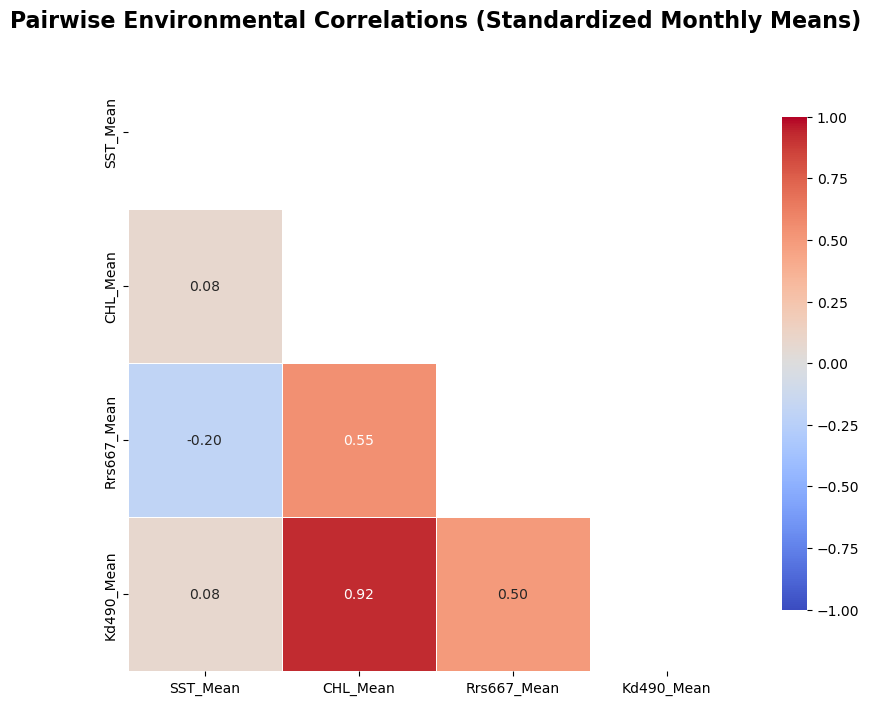

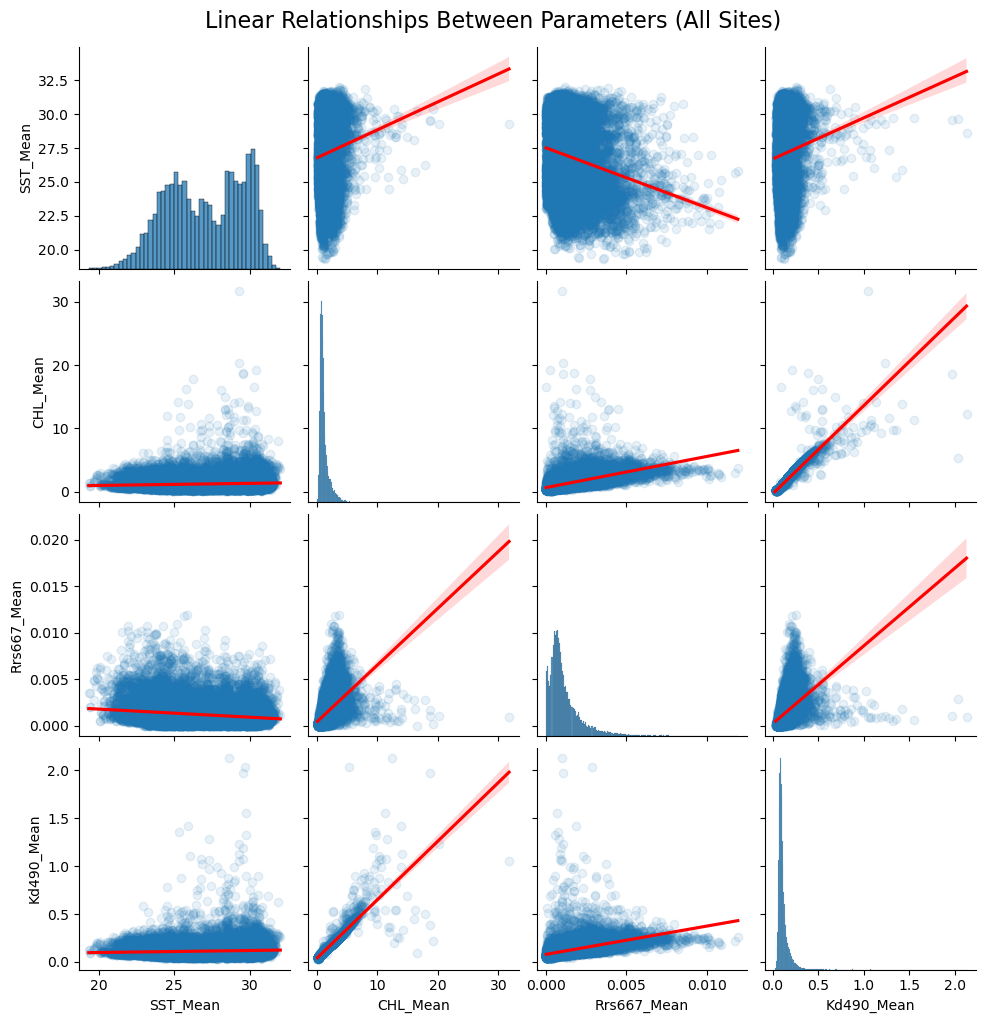

In [31]:
# --- 1. PREPARE THE DATA ---
# We select only the numeric environmental parameters
cols_to_corr = ['SST_Mean', 'CHL_Mean', 'Rrs667_Mean', 'Kd490_Mean']
df_corr_input = df_rls_master[cols_to_corr]

# --- 2. CALCULATE CORRELATION MATRIX ---
# pearson is standard; use 'spearman' if you expect non-linear relationships
corr_matrix = df_corr_input.corr(method='pearson')

# --- 3. PLOT THE HEATMAP ---
plt.figure(figsize=(10, 8))

# Create a mask to hide the upper triangle since the matrix is symmetric
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Configure the heatmap
sns.heatmap(corr_matrix, 
            mask=mask, 
            annot=True,          # Show the correlation numbers
            fmt=".2f",           # Round to 2 decimals
            cmap='coolwarm',     # Red for positive, blue for negative
            vmin=-1, vmax=1,     # Correlation scale is always -1 to 1
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .8})

plt.title('Pairwise Environmental Correlations (Standardized Monthly Means)', 
          fontsize=16, fontweight='bold', pad=20)
plt.show()

# --- 4. OPTIONAL: SCATTERPLOT MATRIX (Site-specific variations) ---
# This shows the actual distribution of the relationships
sns.pairplot(df_rls_master, vars=cols_to_corr, kind='reg', 
             plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})
plt.suptitle('Linear Relationships Between Parameters (All Sites)', y=1.02, fontsize=16)
plt.show()

/tmp/ipykernel_1501084/68484857.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


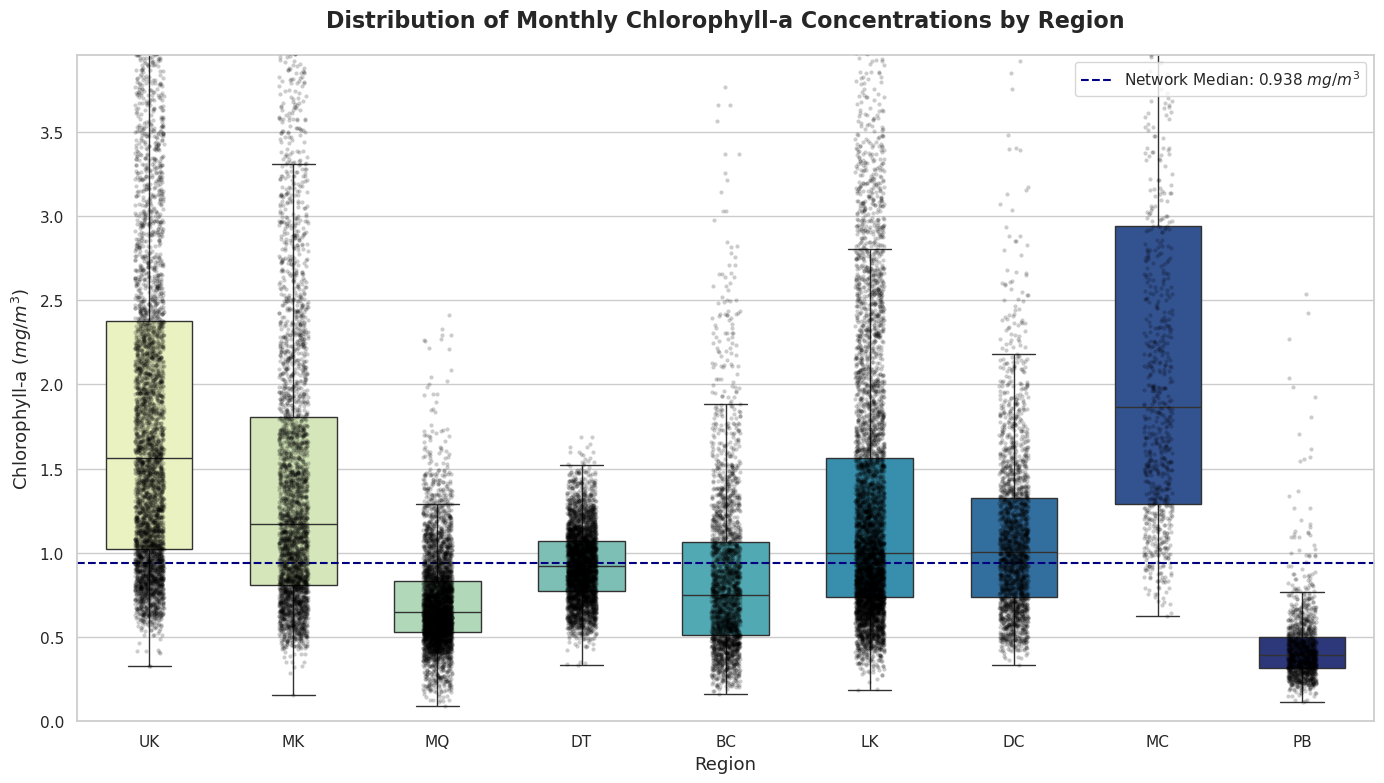

Descriptive Statistics for CHL ($mg/m^3$) per Region:


,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
BC,2494.0,0.8726,0.5809,0.1637,0.5111,0.7498,1.0624,12.3279
DC,2232.0,1.1067,0.6027,0.3311,0.7391,1.0033,1.3234,16.6035
DT,3900.0,0.9296,0.2139,0.3354,0.7712,0.9217,1.0714,1.6845
LK,5579.0,1.2758,0.7713,0.1850,0.7368,1.0010,1.5646,5.9294
MC,836.0,2.7638,2.7798,0.6256,1.2914,1.8629,2.9397,31.7517
MK,3348.0,1.4494,0.8774,0.1583,0.8090,1.1686,1.8082,8.8309
MQ,4464.0,0.7090,0.2756,0.0895,0.5303,0.6488,0.8352,2.4106
PB,1375.0,0.4437,0.2738,0.1166,0.3135,0.3958,0.4972,5.4678
UK,4459.0,1.9408,1.3088,0.3281,1.0196,1.5623,2.3785,16.1914


In [33]:
# Set a clean, professional theme
sns.set_theme(style="whitegrid")

plt.figure(figsize=(14, 8))

# 1. Create the boxplot
# Using 'region' on the x-axis and 'CHL_Mean' on the y-axis
ax = sns.boxplot(
    data=df_rls_master, 
    x='region', 
    y='CHL_Mean', 
    palette='YlGnBu', 
    showfliers=False,  # Hides extreme outliers for better visual scale
    width=0.6
)

# 2. Overlay individual data points (stripplot)
# This adds transparency to the sample density in each region
sns.stripplot(
    data=df_rls_master, 
    x='region', 
    y='CHL_Mean', 
    color='black', 
    alpha=0.2, 
    jitter=True, 
    size=3
)

# 3. Add a horizontal line for the network-wide median
network_median = df_rls_master['CHL_Mean'].median()
plt.axhline(network_median, color='navy', linestyle='--', linewidth=1.5, 
            label=f'Network Median: {network_median:.3f} $mg/m^3$')

# 4. Formatting and Labels
plt.title('Distribution of Monthly Chlorophyll-a Concentrations by Region', 
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Chlorophyll-a ($mg/m^3$)', fontsize=13)
plt.xlabel('Region', fontsize=13)

# Since CHL can have high spikes, ensure the y-axis is readable
plt.ylim(0, df_rls_master['CHL_Mean'].quantile(0.98)) # Zoom in on the bulk of the data

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# --- 5. STATISTICAL SUMMARY ---
print("Descriptive Statistics for CHL ($mg/m^3$) per Region:")
display(df_rls_master.groupby('region')['CHL_Mean'].describe().round(4))